# Scenario I – Body Fat Mass Prediction (Women dataset)

Objective: Develop and validate a multiple linear regression model to predict body fat density
using anthropometric measurements.


<b><span style="color:red;">Note importante: je pense pas avoir bien compris où était le bon moment pour faire handling multicolinéarité et outliers dans le livre de Montgomery explique pas si on doit les enlever direcetement et comment</span></b>


In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [482]:
df = pd.read_csv('bodyfat_women.csv')

In [483]:
print(df.head())
print(df.info())

    age  DEXfat  waistcirc  hipcirc  elbowbreadth  kneebreadth  anthro3a  \
0  57.0   41.68      100.0    112.0           7.1          9.4      4.42   
1  65.0   43.29       99.5    116.5           6.5          8.9      4.63   
2  59.0   35.41       96.0    108.5           6.2          8.9      4.12   
3  58.0   22.79       72.0     96.5           6.1          9.2      4.03   
4  60.0   36.42       89.5    100.5           7.1         10.0      4.24   

   anthro3b  anthro3c  anthro4  
0      4.95      4.50     6.13  
1      5.01      4.48     6.37  
2      4.74      4.60     5.82  
3      4.48      3.91     5.66  
4      4.68      4.15     5.91  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           71 non-null     float64
 1   DEXfat        71 non-null     float64
 2   waistcirc     71 non-null     float64
 3   hipcirc       71 non-n

### Distribution of variables

Histograms are used to assess the shape, symmetry and potential skewness of each variable.
This helps to identify variables that may require transformation.

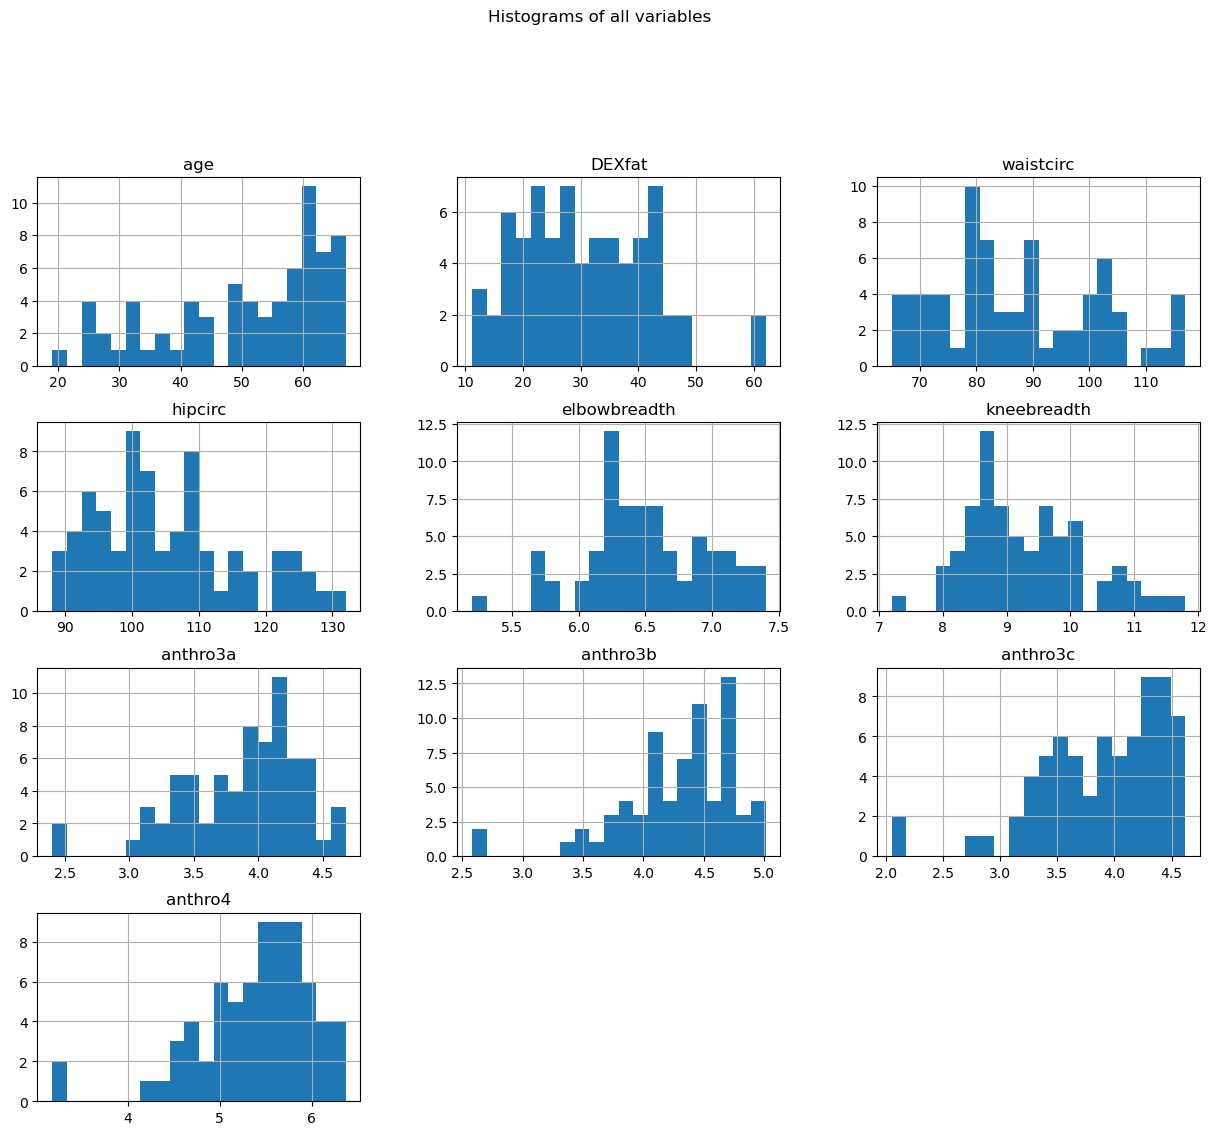

In [484]:
df.hist(figsize=(15, 12), bins=20)
plt.suptitle("Histograms of all variables", y=1.02)
plt.show()

### Relationship between predictors and DEXfat

Scatterplots are used to visually assess linear relationships between each predictor and
the response variable DEXfat.


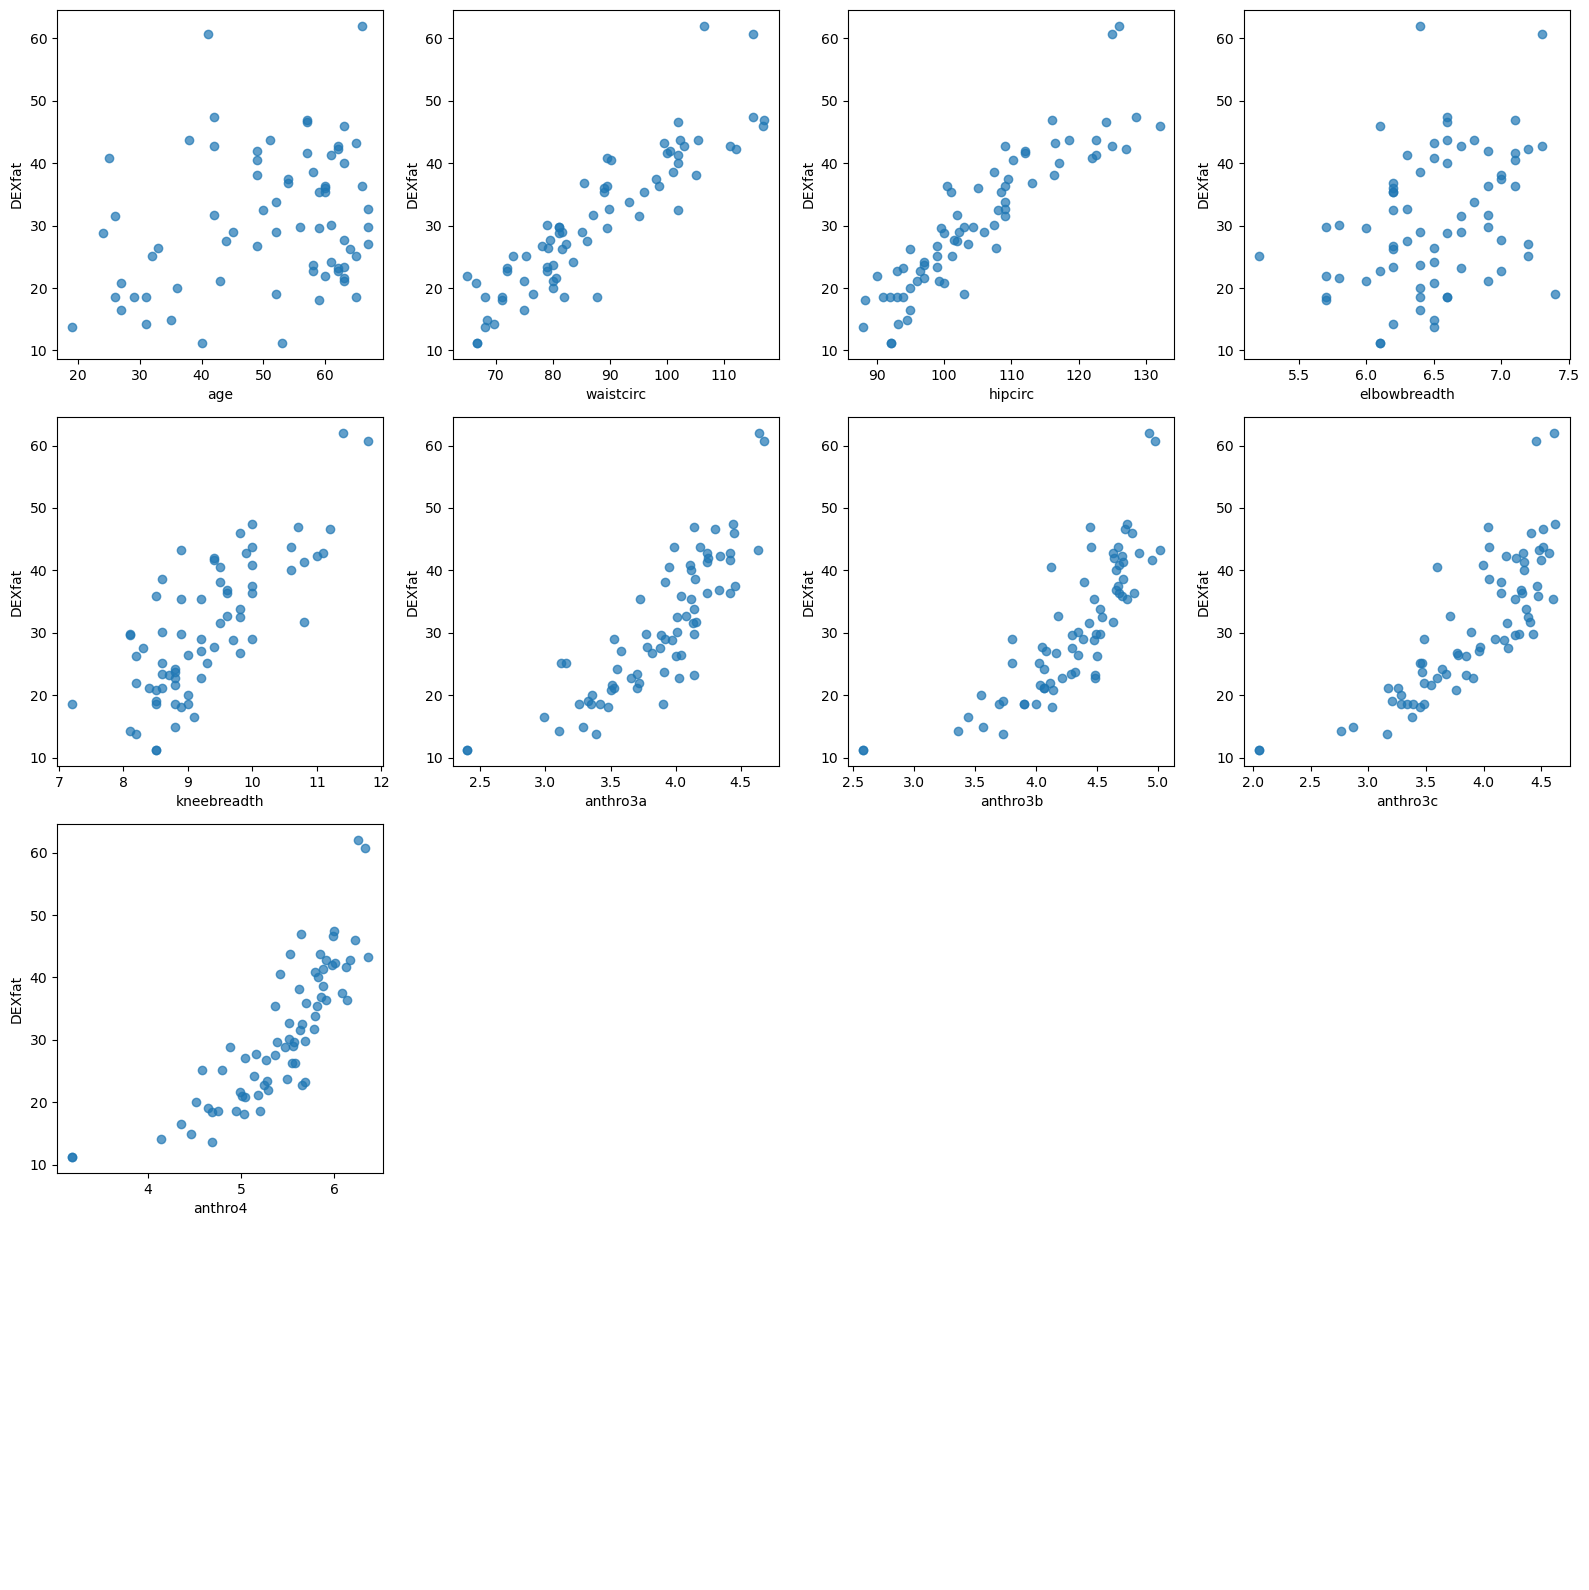

In [485]:
predictors = df.columns.drop("DEXfat")

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for i, col in enumerate(predictors):
    axes[i].scatter(df[col], df["DEXfat"], alpha=0.7)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("DEXfat")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### Correlation analysis

The correlation matrix is computed to identify strong linear relationships between
predictors and the response, as well as potential multicollinearity among predictors.


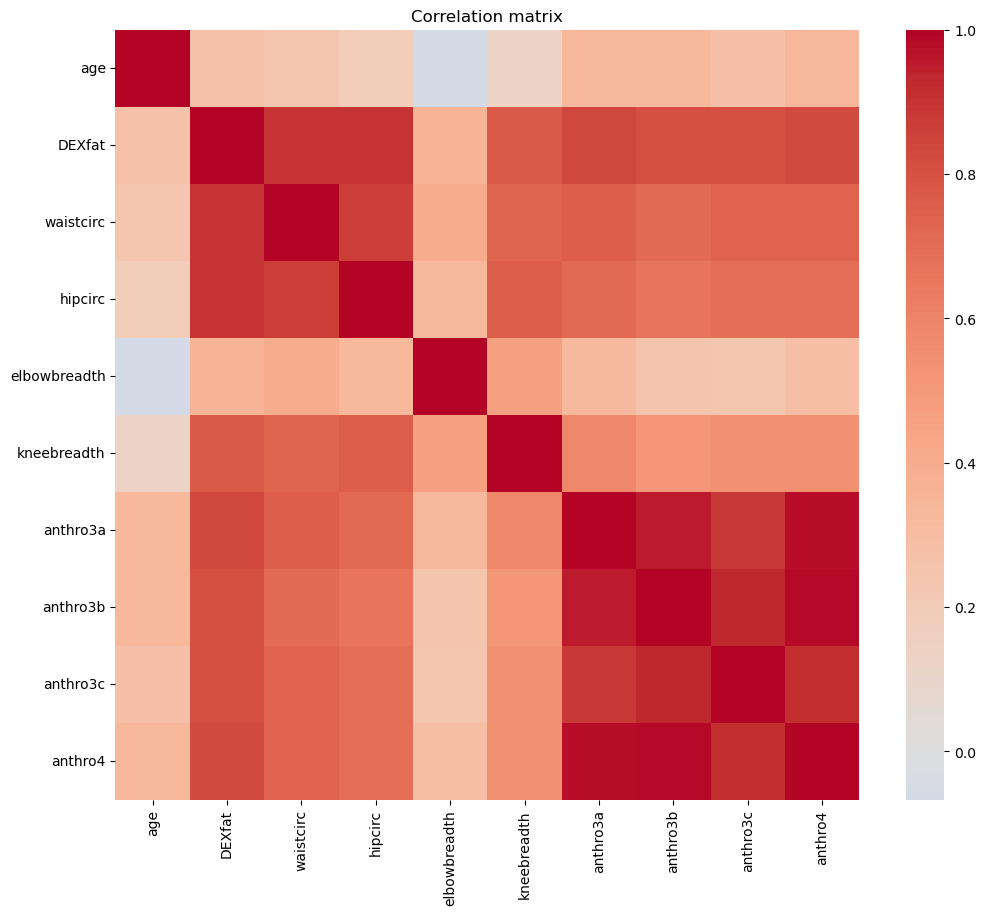

In [486]:
corr_matrix = df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation matrix")
plt.show()


##### Now we are going to follow the STRATEGY FOR VARIABLE SELECTION AND MODEL BUILDING from the Montgomery et al book

## Initial Regression Model

We begin by fitting a model including all available predictors.

In [487]:
# linear regression on all the data available 

X=df.drop('DEXfat',axis=1)
y=df['DEXfat']

# model
X_with_const = sm.add_constant(X) # to add intercept 
model_full = sm.OLS(y, X_with_const).fit() # use of sm to get a simple linear reg
print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:                 DEXfat   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     81.35
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           1.39e-30
Time:                        23:12:18   Log-Likelihood:                -179.71
No. Observations:                  71   AIC:                             379.4
Df Residuals:                      61   BIC:                             402.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -69.0283      7.517     -9.183   

### Full Model Interpretation

**Overall quality:**
- R² = [value] : [interpretation]
- Adjusted R² = [value] : [comparison with R²]
- F-statistic = [value], p-value = [value] : [global significance]

**Significant coefficients:**
- List variables with p < 0.05
- Interpret coefficient signs

**Potential problems detected:**
- Non-significant variables
- Counter-intuitive coefficient signs

### 2) Perform a thorough analysis of this model.

• What regressors seem important?

• Are there possible outliers?

• Is there a need to transform the response?

• Do any of the regressors need transformations?

<b><span style="color:red;">Note: potentiellement verifier avec un TA interpretation des plots pour être sures</span></b>


## Residual Analysis

Residual analysis allows checking the assumptions of the linear model:
1. Linearity
2. Homoscedasticity (constant variance)
3. Normality of residuals
4. Independence of residuals

### Types of Residuals
- **Raw residuals**: eᵢ = yᵢ - ŷᵢ
- **Standardized residuals**: eᵢ / σ̂
- **Studentized residuals**: account for leverage

In [488]:
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.nonparametric.smoothers_lowess import lowess

def diagnostic(model=model_full):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fitted = model.fittedvalues
    residuals = model.resid
    influence = OLSInfluence(model)

    standardized_resid = influence.resid_studentized_internal
    leverage = influence.hat_matrix_diag
    cooks_d = influence.cooks_distance[0]

    # 1. Residuals vs Fitted
    axes[0, 0].scatter(fitted, residuals, alpha=0.6)
    lowess_line = lowess(residuals, fitted, frac=0.6)
    axes[0, 0].plot(lowess_line[:, 0], lowess_line[:, 1], 'r-', linewidth=2)
    axes[0, 0].axhline(y=0, color='black', linestyle='--')
    axes[0, 0].set_xlabel('Fitted values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted')

    # 2. Q-Q Plot
    from scipy import stats
    stats.probplot(standardized_resid, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Normal Q-Q')

    # 3. Scale-Location
    sqrt_std_resid = np.sqrt(np.abs(standardized_resid))
    axes[0, 2].scatter(fitted, sqrt_std_resid, alpha=0.6)
    lowess_line2 = lowess(sqrt_std_resid, fitted, frac=0.6)
    axes[0, 2].plot(lowess_line2[:, 0], lowess_line2[:, 1], 'r-', linewidth=2)
    axes[0, 2].set_xlabel('Fitted values')
    axes[0, 2].set_ylabel('√|Standardized residuals|')
    axes[0, 2].set_title('Scale-Location')

    # 4. Residuals vs Leverage
    axes[1, 0].scatter(leverage, standardized_resid, alpha=0.6)
    axes[1, 0].axhline(y=0, color='black', linestyle='--')
    axes[1, 0].set_xlabel('Leverage')
    axes[1, 0].set_ylabel('Standardized residuals')
    axes[1, 0].set_title('Residuals vs Leverage')

    # 5. Cook's distance
    axes[1, 1].stem(range(len(cooks_d)), cooks_d, markerfmt=',')
    axes[1, 1].set_xlabel('Observation')
    axes[1, 1].set_ylabel("Cook's distance")
    axes[1, 1].set_title("Cook's distance")
    
    # 6. Histogram of residuals
    axes[1, 2].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
    axes[1, 2].set_xlabel('Residuals')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Histogram of residuals')
    
    plt.tight_layout()
    plt.show()


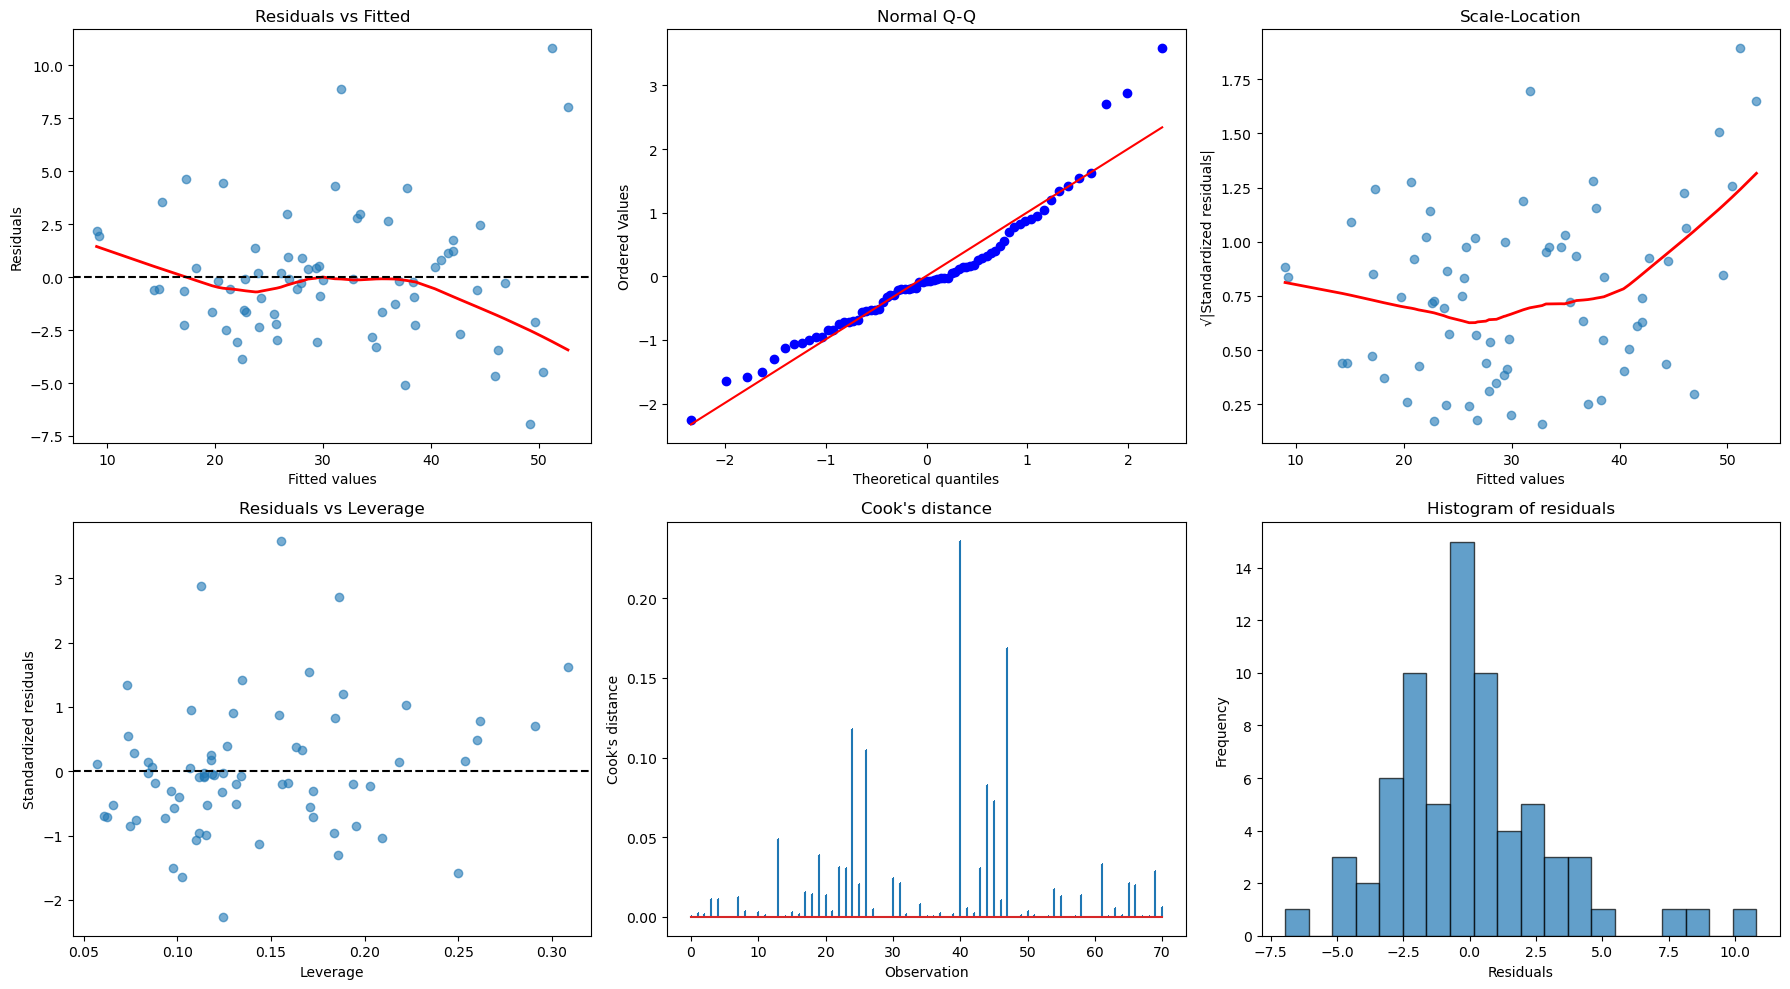

In [489]:
diagnostic(model_full)



OBSERVATIONS:
1. Residuals vs Fitted:
The lowess curve shows a non-linear pattern (curved, not horizontal at 0), and the spread of residuals increases with fitted values, indicating heteroscedasticity (non-constant variance). Points 26, 40, and 47 have very high standardized residuals and appear as outliers that should be investigated.

2. Q-Q Plot:
Points 26, 40, and 47 deviate strongly from the theoretical normal line, particularly in the upper tail. This suggests that the residuals may not follow a normal distribution perfectly, likely due to these outlier observations. The majority of points follow the diagonal line reasonably well, indicating approximate normality for the rest of the data.

3. Scale-Location:
The lowess curve shows an upward trend, confirming heteroscedasticity (the variance of residuals increases with fitted values). Points 26, 40, and 47 have the highest √|standardized residuals|, indicating they are the most extreme observations in terms of residual magnitude.

4. Cook's Distance:
Point 40 has the highest Cook's distance (approximately 0.25), indicating it is the most influential observation. Points 24 and 47 also show elevated Cook's distance values. Using the cutoff of 4/n ≈ 0.056 (where n=71), these three points far exceed this threshold, suggesting they have substantial influence on the regression coefficients.
Note: Point 24 appears in this plot but not in the residual plots, indicating it has moderate residual combined with high leverage, making it influential. Point 26, despite having a large residual, has lower leverage and thus lower Cook's distance than point 24.

5. Residuals vs Leverage:
Point 40 has moderate leverage combined with the highest standardized residual, making it the most influential observation. Points 26 and 47 also have high standardized residuals with moderate leverage, making them influential outliers. All three points fall within the Cook's distance = 0.5 contour, but point 40 is closest to this boundary. The lowess curve shows the general trend of residuals across different leverage values.



### Residual Analysis Interpretation

**Linearity:**
- Residuals vs Fitted plot: [observed pattern]
- Conclusion: [linearity verified / problem detected]

**Normality:**
- Q-Q Plot: [adherence to diagonal]
- Jarque-Bera test: p = [value]
- Conclusion: [normality verified / violations]

**Homoscedasticity:**
- Scale-Location plot: [observed pattern]
- Breusch-Pagan test: p = [value]
- Conclusion: [constant variance / heteroscedasticity]

**Required actions:**
- List of identified problems
- Transformations to consider

In [490]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.nonparametric.smoothers_lowess import lowess

def compare_transfo(model1, model2, name1='Full Model', name2='Transformed Model'):
    models = {0: (name1, model1), 1: (name2, model2)}
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Regression Diagnostics Comparison', fontsize=16, fontweight='bold', y=0.995)
    
    for i, (name, model) in models.items():
        fitted = model.fittedvalues
        residuals = model.resid
        influence = OLSInfluence(model)
        standardized_resid = influence.resid_studentized_internal
        
        # Residuals vs Fitted
        axes[i, 0].scatter(fitted, residuals, alpha=0.6)
        lowess_line = lowess(residuals, fitted, frac=0.6)
        axes[i, 0].plot(lowess_line[:, 0], lowess_line[:, 1], 'r-', linewidth=2)
        axes[i, 0].axhline(y=0, color='black', linestyle='--')
        axes[i, 0].set_title(f'{name} - Residuals vs Fitted')
        axes[i, 0].set_xlabel('Fitted values')
        axes[i, 0].set_ylabel('Residuals')
        
        # Q-Q Plot
        from scipy import stats
        stats.probplot(standardized_resid, dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title(f'{name} - Normal Q-Q')
        
        # Scale-Location
        sqrt_std_resid = np.sqrt(np.abs(standardized_resid))
        axes[i, 2].scatter(fitted, sqrt_std_resid, alpha=0.6)
        lowess_line2 = lowess(sqrt_std_resid, fitted, frac=0.6)
        axes[i, 2].plot(lowess_line2[:, 0], lowess_line2[:, 1], 'r-', linewidth=2)
        axes[i, 2].set_title(f'{name} - Scale-Location')
        axes[i, 2].set_xlabel('Fitted values')
        axes[i, 2].set_ylabel('√|Standardized residuals|')
    
    plt.tight_layout()
    plt.show()



## Diagnostic of Influential Observations

We identify observations that have a disproportionate influence on the model:
- **Outliers**: extreme values on Y
- **High leverage points**: extreme values on X
- **Influential points**: strongly impact coefficients

OUTLIERS, LEVERAGE, AND INFLUENCE DIAGNOSTICS
Sample size: n = 71
Number of parameters: p = 10.0

Cutoff values:
  Cook's distance        > 0.0563
  Leverage               > 0.2817
  |DFFITS|               > 0.7506
  |Studentized residual| > 3
  |CovRatio - 1|         > 0.4225

Identified observations:
Influential points (Cook's D): [24 26 40 44 45 47]
High leverage points:          [24 66]
DFFITS outliers:               [24 26 40 44 45 47]
Studentized residual outliers: [26 40]
CovRatio problems:             [26 34 35 40 45 47 49 53 64 65 66]


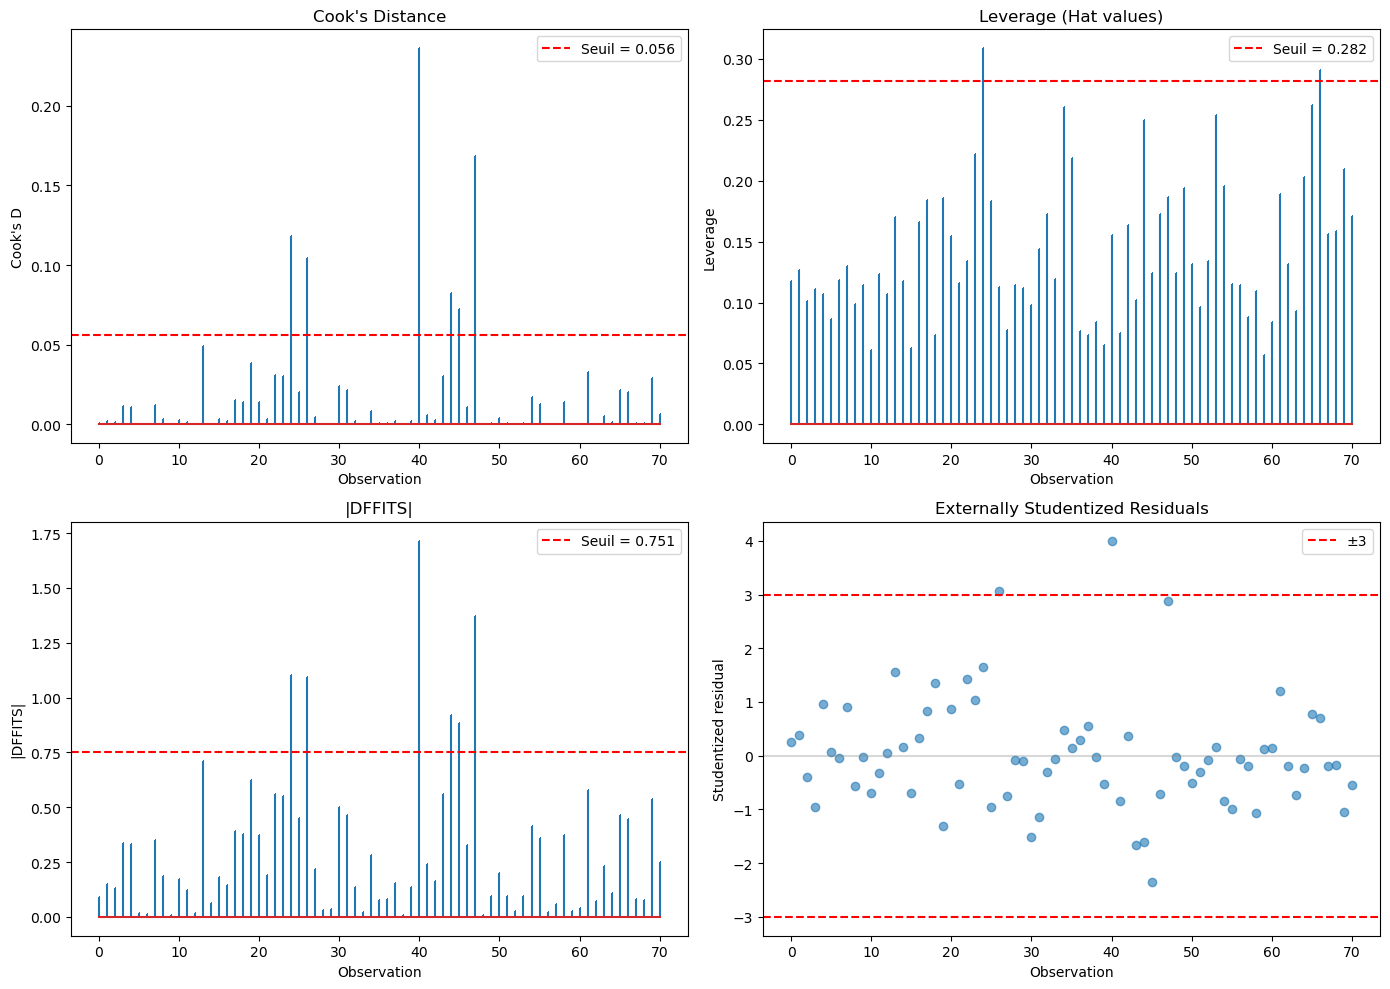


Total problematic observations: 13


,observation,cooks_d,leverage,dffits,student_resid,covratio,high_cooks,high_leverage,high_dffits,high_resid,covratio_problem
24,24,0.118185,0.308643,1.102367,1.649867,1.094947,True,True,True,False,False
26,26,0.104772,0.112439,1.091870,3.067696,0.309622,True,False,True,True,True
34,34,0.008174,0.260153,0.284093,0.479090,1.534835,False,False,False,False,True
35,35,0.000600,0.218659,0.076851,0.145274,1.504588,False,False,False,False,True
40,40,0.236192,0.155198,1.715697,4.002908,0.130942,True,False,True,True,True
44,44,0.082757,0.249684,-0.921196,-1.596903,1.036989,True,False,True,False,False
45,45,0.072719,0.124154,-0.883708,-2.347155,0.559567,True,False,True,False,True
47,47,0.168762,0.186361,1.374046,2.871040,0.400215,True,False,True,False,True
49,49,0.000916,0.193713,-0.094972,-0.193759,1.454051,False,False,False,False,True
53,53,0.000881,0.253421,0.093123,0.159836,1.573480,False,False,False,False,True


In [491]:
from statsmodels.stats.outliers_influence import OLSInfluence
import numpy as np
import pandas as pd

# Influence object
influence = OLSInfluence(model_full)

# Core influence measures
cooks_d = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag
covratio = influence.cov_ratio

# Missing but important diagnostics
dffits = influence.dffits[0]
student_resid = influence.resid_studentized_external

# Dimensions
n = len(y)
p = model_full.df_model + 1  # including intercept

# Cutoff values
cooks_cutoff = 4 / n
leverage_cutoff = 2 * p / n
dffits_cutoff = 2 * np.sqrt(p / n)
student_cutoff = 3
covratio_cutoff = 3 * p / n

print("OUTLIERS, LEVERAGE, AND INFLUENCE DIAGNOSTICS")
print("=" * 60)
print(f"Sample size: n = {n}")
print(f"Number of parameters: p = {p}")

print("\nCutoff values:")
print(f"  Cook's distance        > {cooks_cutoff:.4f}")
print(f"  Leverage               > {leverage_cutoff:.4f}")
print(f"  |DFFITS|               > {dffits_cutoff:.4f}")
print(f"  |Studentized residual| > {student_cutoff}")
print(f"  |CovRatio - 1|         > {covratio_cutoff:.4f}")



# Identify problematic observations
cooks_outliers = np.where(cooks_d > cooks_cutoff)[0]
leverage_outliers = np.where(leverage > leverage_cutoff)[0]
dffits_outliers = np.where(np.abs(dffits) > dffits_cutoff)[0]
student_outliers = np.where(np.abs(student_resid) > student_cutoff)[0]
covratio_problems = np.where(np.abs(covratio - 1) > covratio_cutoff)[0]

print("\nIdentified observations:")
print(f"Influential points (Cook's D): {cooks_outliers}")
print(f"High leverage points:          {leverage_outliers}")
print(f"DFFITS outliers:               {dffits_outliers}")
print(f"Studentized residual outliers: {student_outliers}")
print(f"CovRatio problems:             {covratio_problems}")

# Summary DataFrame
influence_df = pd.DataFrame({
    "observation": np.arange(n),
    "cooks_d": cooks_d,
    "leverage": leverage,
    "dffits": dffits,
    "student_resid": student_resid,
    "covratio": covratio,
})
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cook's Distance
axes[0, 0].stem(influence_df["observation"], influence_df["cooks_d"], markerfmt=',')
axes[0, 0].axhline(cooks_cutoff, color='r', linestyle='--',
                   label=f'Seuil = {cooks_cutoff:.3f}')
axes[0, 0].set_title("Cook's Distance")
axes[0, 0].set_xlabel("Observation")
axes[0, 0].set_ylabel("Cook's D")
axes[0, 0].legend()

# 2. Leverage (Hat values)
axes[0, 1].stem(influence_df["observation"], influence_df["leverage"], markerfmt=',')
axes[0, 1].axhline(leverage_cutoff, color='r', linestyle='--',
                   label=f'Seuil = {leverage_cutoff:.3f}')
axes[0, 1].set_title("Leverage (Hat values)")
axes[0, 1].set_xlabel("Observation")
axes[0, 1].set_ylabel("Leverage")
axes[0, 1].legend()

# 3. DFFITS
axes[1, 0].stem(influence_df["observation"],
                np.abs(influence_df["dffits"]),
                markerfmt=',')
axes[1, 0].axhline(dffits_cutoff, color='r', linestyle='--',
                   label=f'Seuil = {dffits_cutoff:.3f}')
axes[1, 0].set_title("|DFFITS|")
axes[1, 0].set_xlabel("Observation")
axes[1, 0].set_ylabel("|DFFITS|")
axes[1, 0].legend()

# 4. Externally studentized residuals
axes[1, 1].scatter(influence_df["observation"],
                   influence_df["student_resid"],
                   alpha=0.6)
axes[1, 1].axhline(student_cutoff, color='r', linestyle='--',
                   label=f'±{student_cutoff}')
axes[1, 1].axhline(-student_cutoff, color='r', linestyle='--')
axes[1, 1].axhline(0, color='gray', linestyle='-', alpha=0.3)
axes[1, 1].set_title("Externally Studentized Residuals")
axes[1, 1].set_xlabel("Observation")
axes[1, 1].set_ylabel("Studentized residual")
axes[1, 1].legend()

plt.tight_layout()
plt.show()


# Flags
influence_df["high_cooks"] = influence_df["cooks_d"] > cooks_cutoff
influence_df["high_leverage"] = influence_df["leverage"] > leverage_cutoff
influence_df["high_dffits"] = np.abs(influence_df["dffits"]) > dffits_cutoff
influence_df["high_resid"] = np.abs(influence_df["student_resid"]) > student_cutoff
influence_df["covratio_problem"] = np.abs(influence_df["covratio"] - 1) > covratio_cutoff

# All problematic points
problematic_obs = influence_df[
    influence_df[[
        "high_cooks",
        "high_leverage",
        "high_dffits",
        "high_resid",
        "covratio_problem"
    ]].any(axis=1)
]

print(f"\nTotal problematic observations: {len(problematic_obs)}")
display(problematic_obs)


### Outlier Treatment Strategy

Based on the previous analysis, we must decide how to treat influential observations.

**Options:**
1. **Keep**: if values are plausible and representative
2. **Examine**: check for measurement or data entry errors
3. **Remove**: if clearly aberrant and unjustifiable
4. **Robust model**: use robust regression

**Decision:**


HANDLING OUTLIERS

Observations suggested for removal: [24]

COMPARISON: ORIGINAL MODEL vs CLEANED MODEL
        Metric    Original       Clean  Difference
0           R²    0.923088    0.926149    0.003060
1  Adjusted R²    0.911740    0.915071    0.003330
2          AIC  379.412515  372.237485   -7.175030
3          BIC  402.039313  394.722437   -7.316876
4         RMSE    3.280640    3.235291   -0.045349

Original dataset: 71 observations
Clean dataset: 70 observations
Removed: 1 observations

MODEL WITHOUT OUTLIERS
                            OLS Regression Results                            
Dep. Variable:                 DEXfat   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     83.60
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           1.42e-30
Time:                        23:12:19   Log-Likelihood:                -176.12


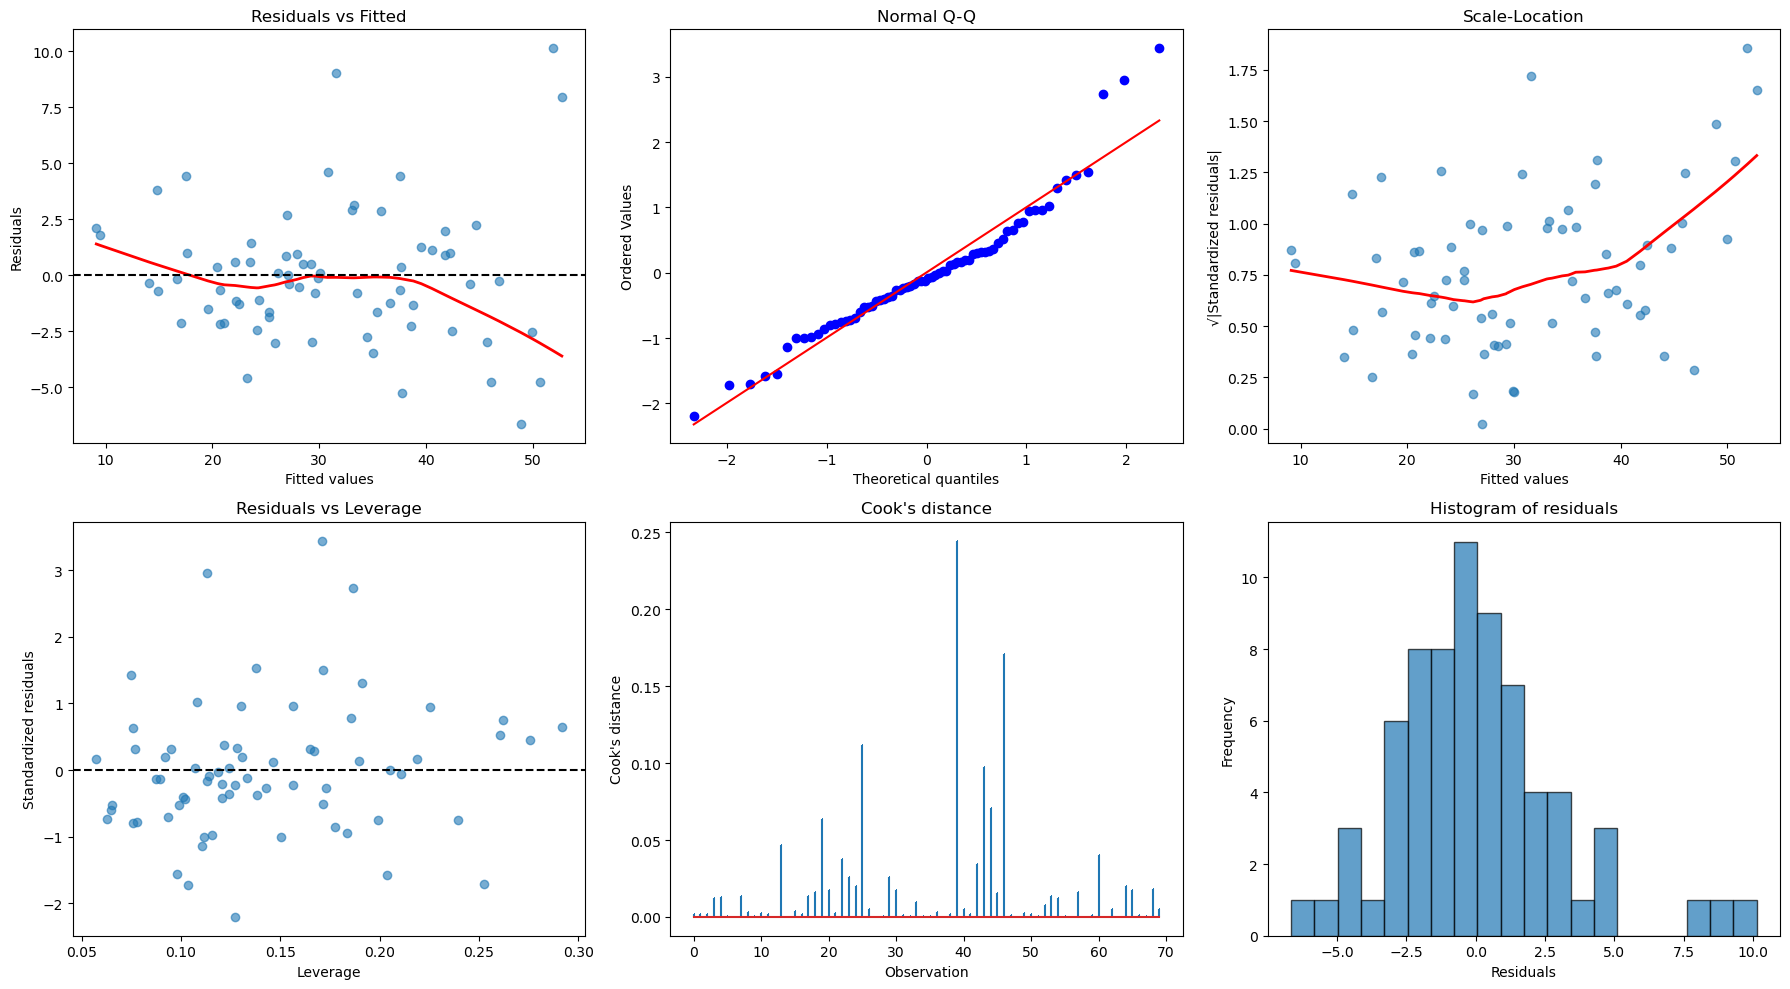

In [492]:
print("\n" + "="*70)
print("HANDLING OUTLIERS")
print("="*70 + "\n")

# Identify observations to potentially remove
obs_to_remove = problematic_obs[
    (problematic_obs['high_cooks']) & 
    (problematic_obs['high_leverage'])
]['observation'].values

if len(obs_to_remove) > 0:
    print(f"Observations suggested for removal: {obs_to_remove}")
    
    # Create dataset without these observations
    df_clean = df.drop(obs_to_remove).reset_index(drop=True)
    
    # Refit model
    X_clean = df_clean.drop('DEXfat', axis=1)
    y_clean = df_clean['DEXfat']
    X_clean_const = sm.add_constant(X_clean)
    
    model_clean = sm.OLS(y_clean, X_clean_const).fit()
    
    print("\n" + "="*60)
    print("COMPARISON: ORIGINAL MODEL vs CLEANED MODEL")
    print("="*60)
    comparison = pd.DataFrame({
        'Metric': ['R²', 'Adjusted R²', 'AIC', 'BIC', 'RMSE'],
        'Original': [
            model_full.rsquared,
            model_full.rsquared_adj,
            model_full.aic,
            model_full.bic,
            np.sqrt(model_full.mse_resid)
        ],
        'Clean': [
            model_clean.rsquared,
            model_clean.rsquared_adj,
            model_clean.aic,
            model_clean.bic,
            np.sqrt(model_clean.mse_resid)
        ]
    })
    comparison['Difference'] = comparison['Clean'] - comparison['Original']
    print(comparison)
else:
    print("No observations require removal according to strict criteria.")
    df_clean = df.copy()
    model_clean = model_full

# Create dataset without outliers
df_clean = df.drop(obs_to_remove)
X_clean = df_clean.drop('DEXfat', axis=1)
y_clean = df_clean['DEXfat']

print(f"\nOriginal dataset: {len(df)} observations")
print(f"Clean dataset: {len(df_clean)} observations")
print(f"Removed: {len(obs_to_remove)} observations")

# Refit le modèle sans outliers
X_clean_const = sm.add_constant(X_clean)
model_clean = sm.OLS(y_clean, X_clean_const).fit()

print("\n" + "="*70)
print("MODEL WITHOUT OUTLIERS")
print("="*70)
print(model_clean.summary())

# Comparer
print("\nComparison:")
print(f"R² with outliers: {model_full.rsquared:.4f}")
print(f"R² without outliers: {model_clean.rsquared:.4f}")

diagnostic(model_clean)

*Observation: According to Cook's distance all those points are influential points [24 26 40 44 45 47] so high leverage and high residuals*

<b><span style="color:red;">Note: important investigate why they are outliers, measure error or ...? </span></b>


## Multicollinearity Diagnostics

Multicollinearity occurs when predictors are highly correlated with each other.

**Consequences:**
- Unstable coefficients
- High standard errors
- Difficult interpretation

**Detection method: VIF (Variance Inflation Factor)**
- VIF < 5: acceptable
- 5 ≤ VIF < 10: moderate multicollinearity
- VIF ≥ 10: severe multicollinearity

In [493]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X_clean.columns
vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) for i in range(X_clean.shape[1])]

print("MULTICOLLINEARITY DIAGNOSTICS")
print("="*60)
print("VIF values (threshold = 10):")
print(vif_data.sort_values('VIF', ascending=False))

corr_matrix = X_clean.corr()
eigenvalues = np.linalg.eigvals(corr_matrix)
condition_number = np.max(eigenvalues) / np.min(eigenvalues)
print(f"\nCondition Number: {condition_number:.2f} (threshold = 100)")

MULTICOLLINEARITY DIAGNOSTICS
VIF values (threshold = 10):
       Variable          VIF
8       anthro4  8242.009926
6      anthro3b  3724.361383
5      anthro3a  2930.896254
7      anthro3c   428.163931
2       hipcirc   409.063972
4   kneebreadth   296.286746
1     waistcirc   194.588666
3  elbowbreadth   165.354924
0           age    18.322252

Condition Number: 983.40 (threshold = 100)


                            OLS Regression Results                            
Dep. Variable:                 DEXfat   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     130.5
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           1.08e-27
Time:                        23:12:20   Log-Likelihood:                -199.55
No. Observations:                  70   AIC:                             407.1
Df Residuals:                      66   BIC:                             416.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -39.4460      7.850     -5.025   

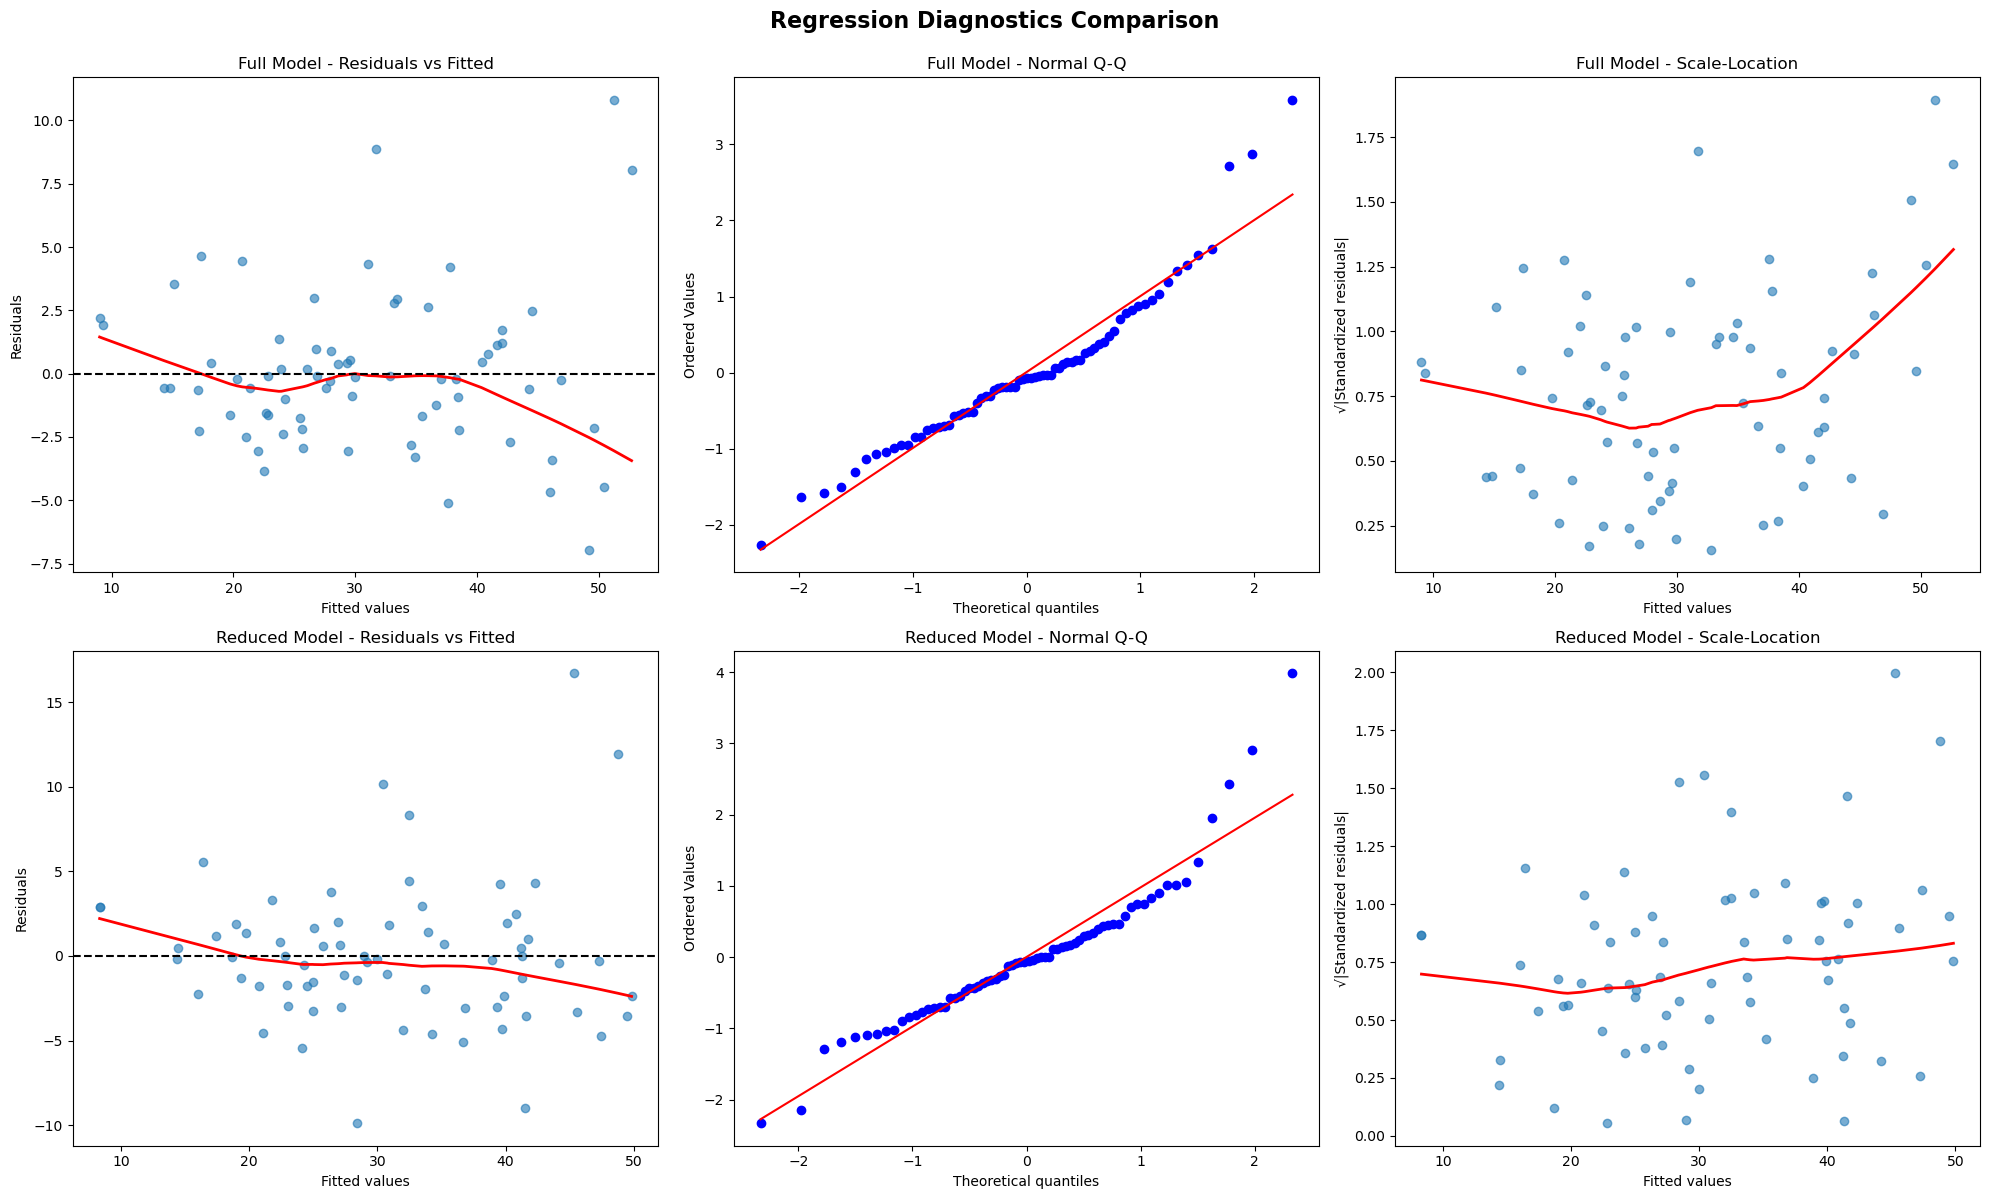

In [494]:
import pandas as pd
import statsmodels.api as sm

# Suppose your DataFrame is called df
# Select the variables to keep
columns_to_keep = [
    'waistcirc',    # Size
    'elbowbreadth', # Bone width
    # 'hipcirc',
    # 'kneebreadth',
    'anthro3c',  
    # 'age'           # Demographics
]
# Create the reduced DataFrame
df_reduced = df_clean[columns_to_keep].copy()


y = df_clean['DEXfat']        
X_reduced = df_reduced  # predictors only
X_reduced_with_const = sm.add_constant(X_reduced)  # add intercept

# Fit the reduced model
reduced_model = sm.OLS(y_clean, X_reduced_with_const).fit()

# Print the summary
print(reduced_model.summary())

compare_transfo(model_full, reduced_model, name1='Full Model', name2='Reduced Model')


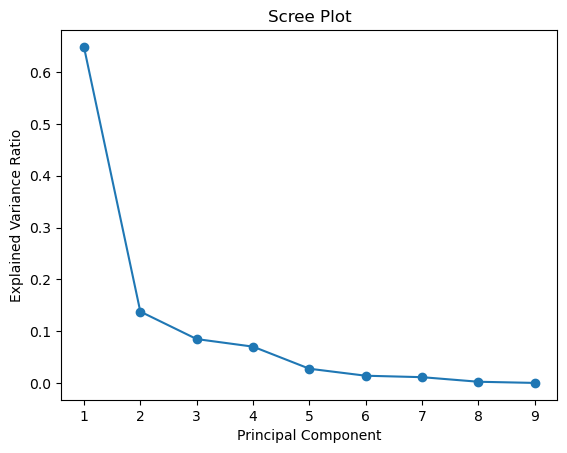

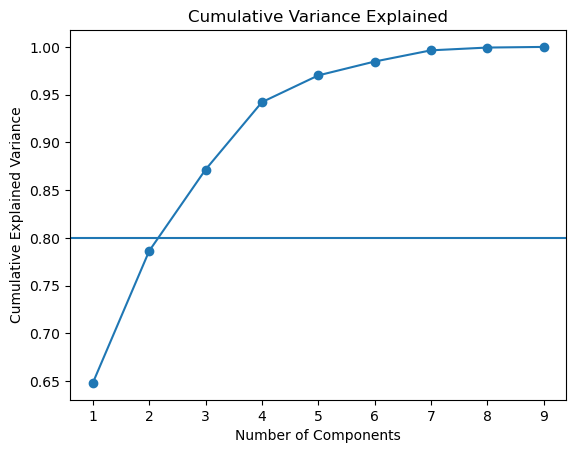

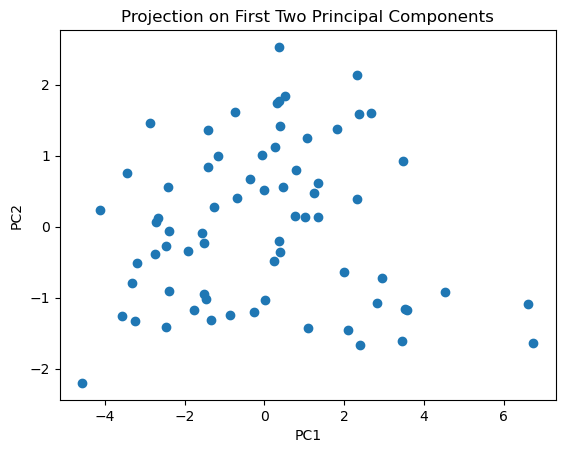

                            OLS Regression Results                            
Dep. Variable:                 DEXfat   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     240.0
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           2.82e-31
Time:                        23:12:21   Log-Likelihood:                -193.83
No. Observations:                  70   AIC:                             393.7
Df Residuals:                      67   BIC:                             400.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.8631      0.471     65.491      0.0

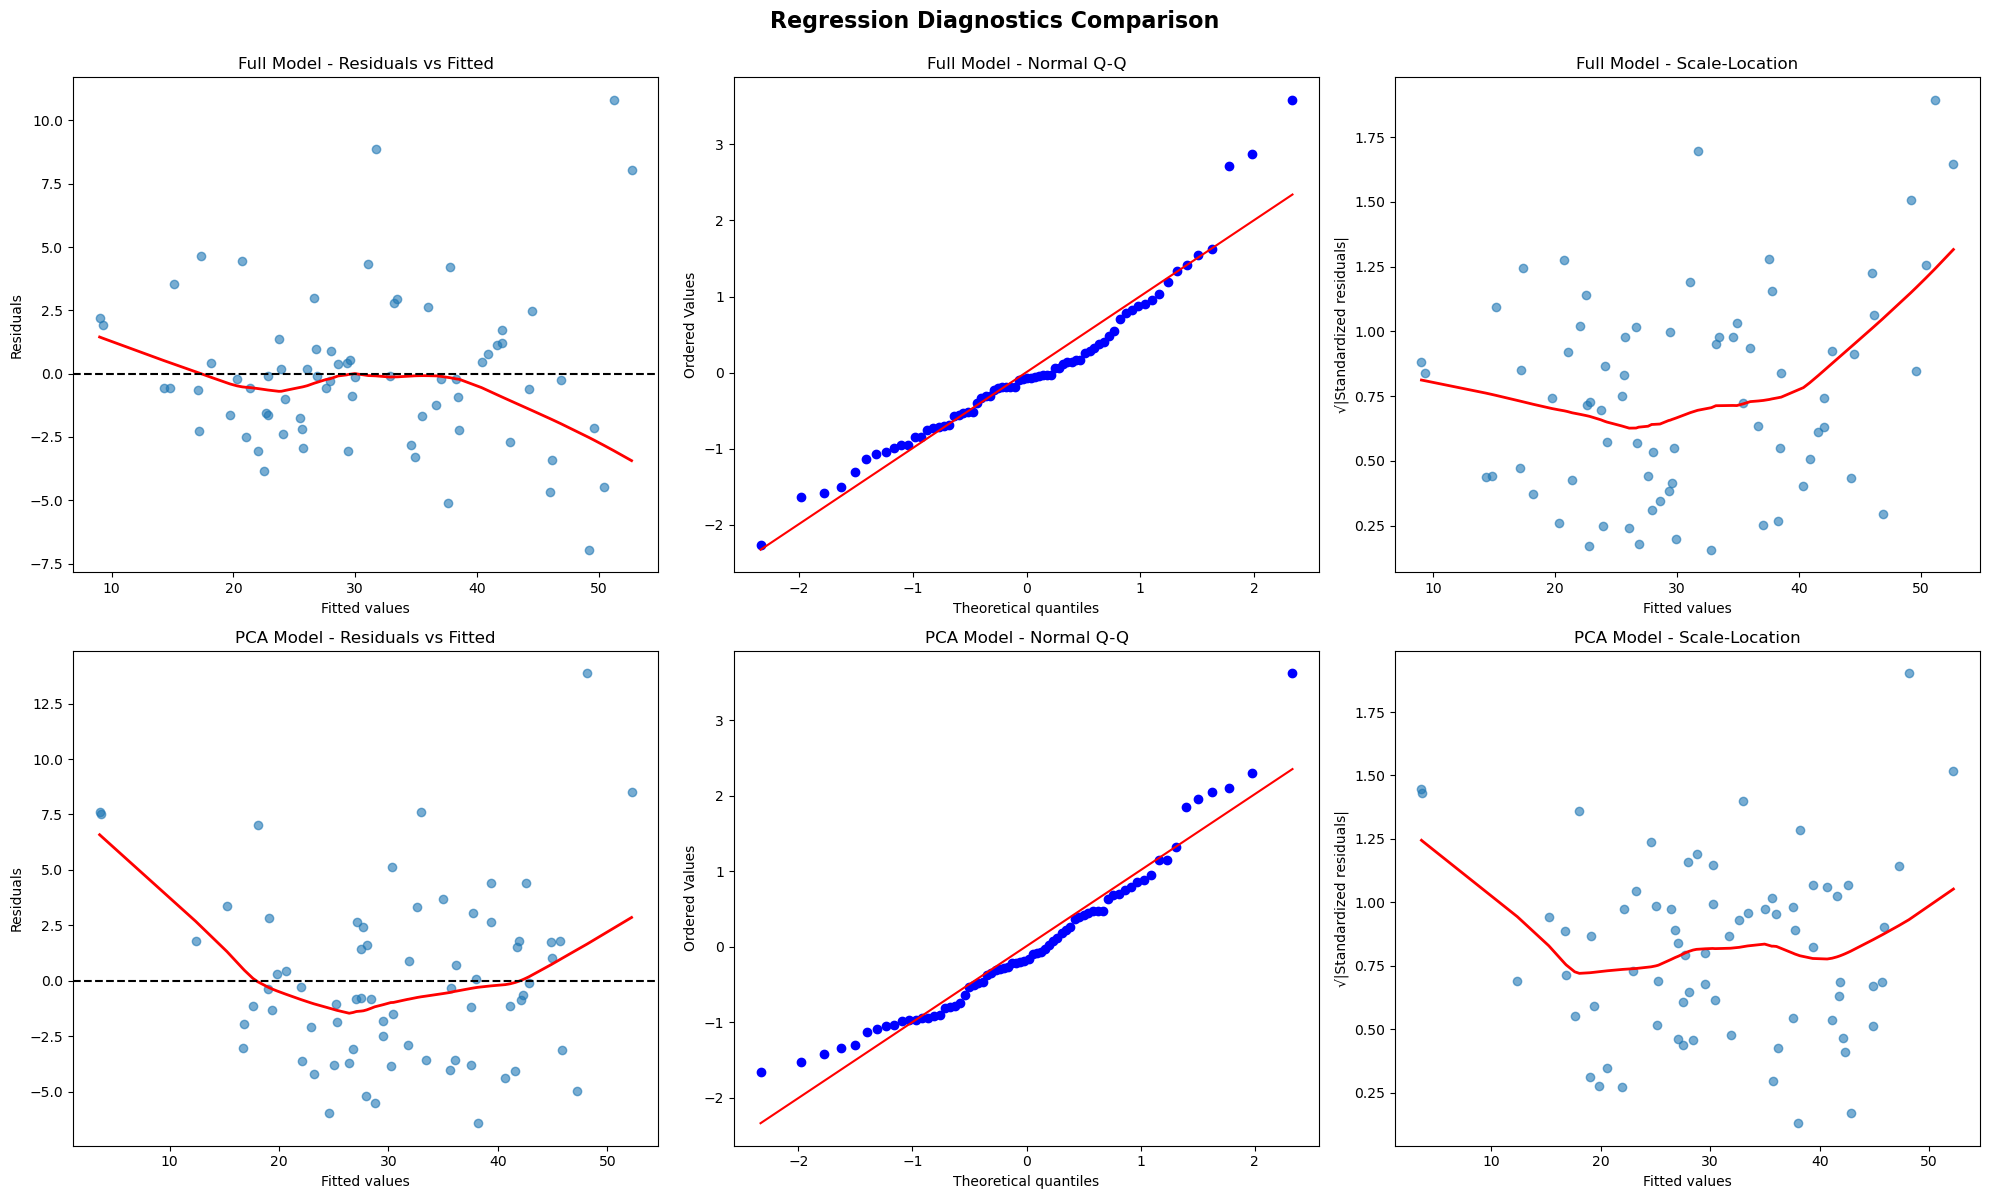

In [495]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

X_scaled = StandardScaler().fit_transform(X_clean)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)
pca.explained_variance_ratio_
pca.explained_variance_ratio_.cumsum()

loadings = pd.DataFrame(
    pca.components_.T,
    index=X_clean.columns,
    columns=[f"PC{i+1}" for i in range(len(pca.components_))]
)


plt.plot(
    np.arange(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_,
    marker='o'
)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.show()
plt.plot(
    np.arange(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker='o'
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Variance Explained")
plt.axhline(0.8)
plt.show()

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Projection on First Two Principal Components")
plt.show()



X_pca_reduced = X_pca[:, :2]  # k = nb de PC gardées
X_pca_reduced_with_const = sm.add_constant(X_pca_reduced)

model_pca = sm.OLS(y_clean, X_pca_reduced_with_const).fit()
print(model_pca.summary())
compare_transfo(model_full, model_pca, name1='Full Model', name2='PCA Model')


*Observation:
Gros problème de multicolinéarité CN>>100*

## Variable Transformations

Transformations can correct:
- Non-linearity
- Heteroscedasticity
- Non-normality of residuals

### Box-Cox Transformation

For response variable Y:
- λ = 1: no transformation
- λ = 0.5: square root
- λ = 0: logarithm
- λ = -1: inverse

<b><span style="color:red;">Note: je pense pas avoir parfaitement fait cette partie. Aussi l'interpretation après avoir appliqué transfo pas ouf</span></b>


In [496]:
from scipy.stats import boxcox

# Box-Cox 
y_transformed, lambda_opt = boxcox(y_clean)
print(f"Lambda optimal: {lambda_opt}")

# Re-fit 
model_boxcox_pca = sm.OLS(y_transformed, X_pca_reduced_with_const).fit()
model_boxcox = sm.OLS(y_transformed, X_reduced_with_const).fit()


Lambda optimal: 0.4485876497365745


In [497]:

def analyze_models_with_transformation(model_full, model_transformed, y_transformed, y_clean):
        print("\n" + "="*60)
        print("MODEL WITH TRANSFORMED Y")
        print("="*60)
        print(model_transformed.summary())
        
        # Decision
        print("\n" + "="*60)
        print("DECISION ON TRANSFORMATION")
        print("="*60)
        # Compare adjusted R² (note: not directly comparable if Y transformed)
        # Use tests on residuals
        jb_orig = jarque_bera(model_clean.resid)[1]
        jb_trans = jarque_bera(model_transformed.resid)[1]
        
        print(f"Residual normality (Jarque-Bera p-value):")
        print(f"  Original model: {jb_orig:.4f}")
        print(f"  Transformed model: {jb_trans:.4f}")
      

In [498]:
analyze_models_with_transformation(model_full, model_boxcox, y_transformed, y_clean)
analyze_models_with_transformation(model_full, model_boxcox_pca, y_transformed, y_clean)


MODEL WITH TRANSFORMED Y
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     168.9
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           6.67e-31
Time:                        23:12:22   Log-Likelihood:                -60.181
No. Observations:                  70   AIC:                             128.4
Df Residuals:                      66   BIC:                             137.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.234

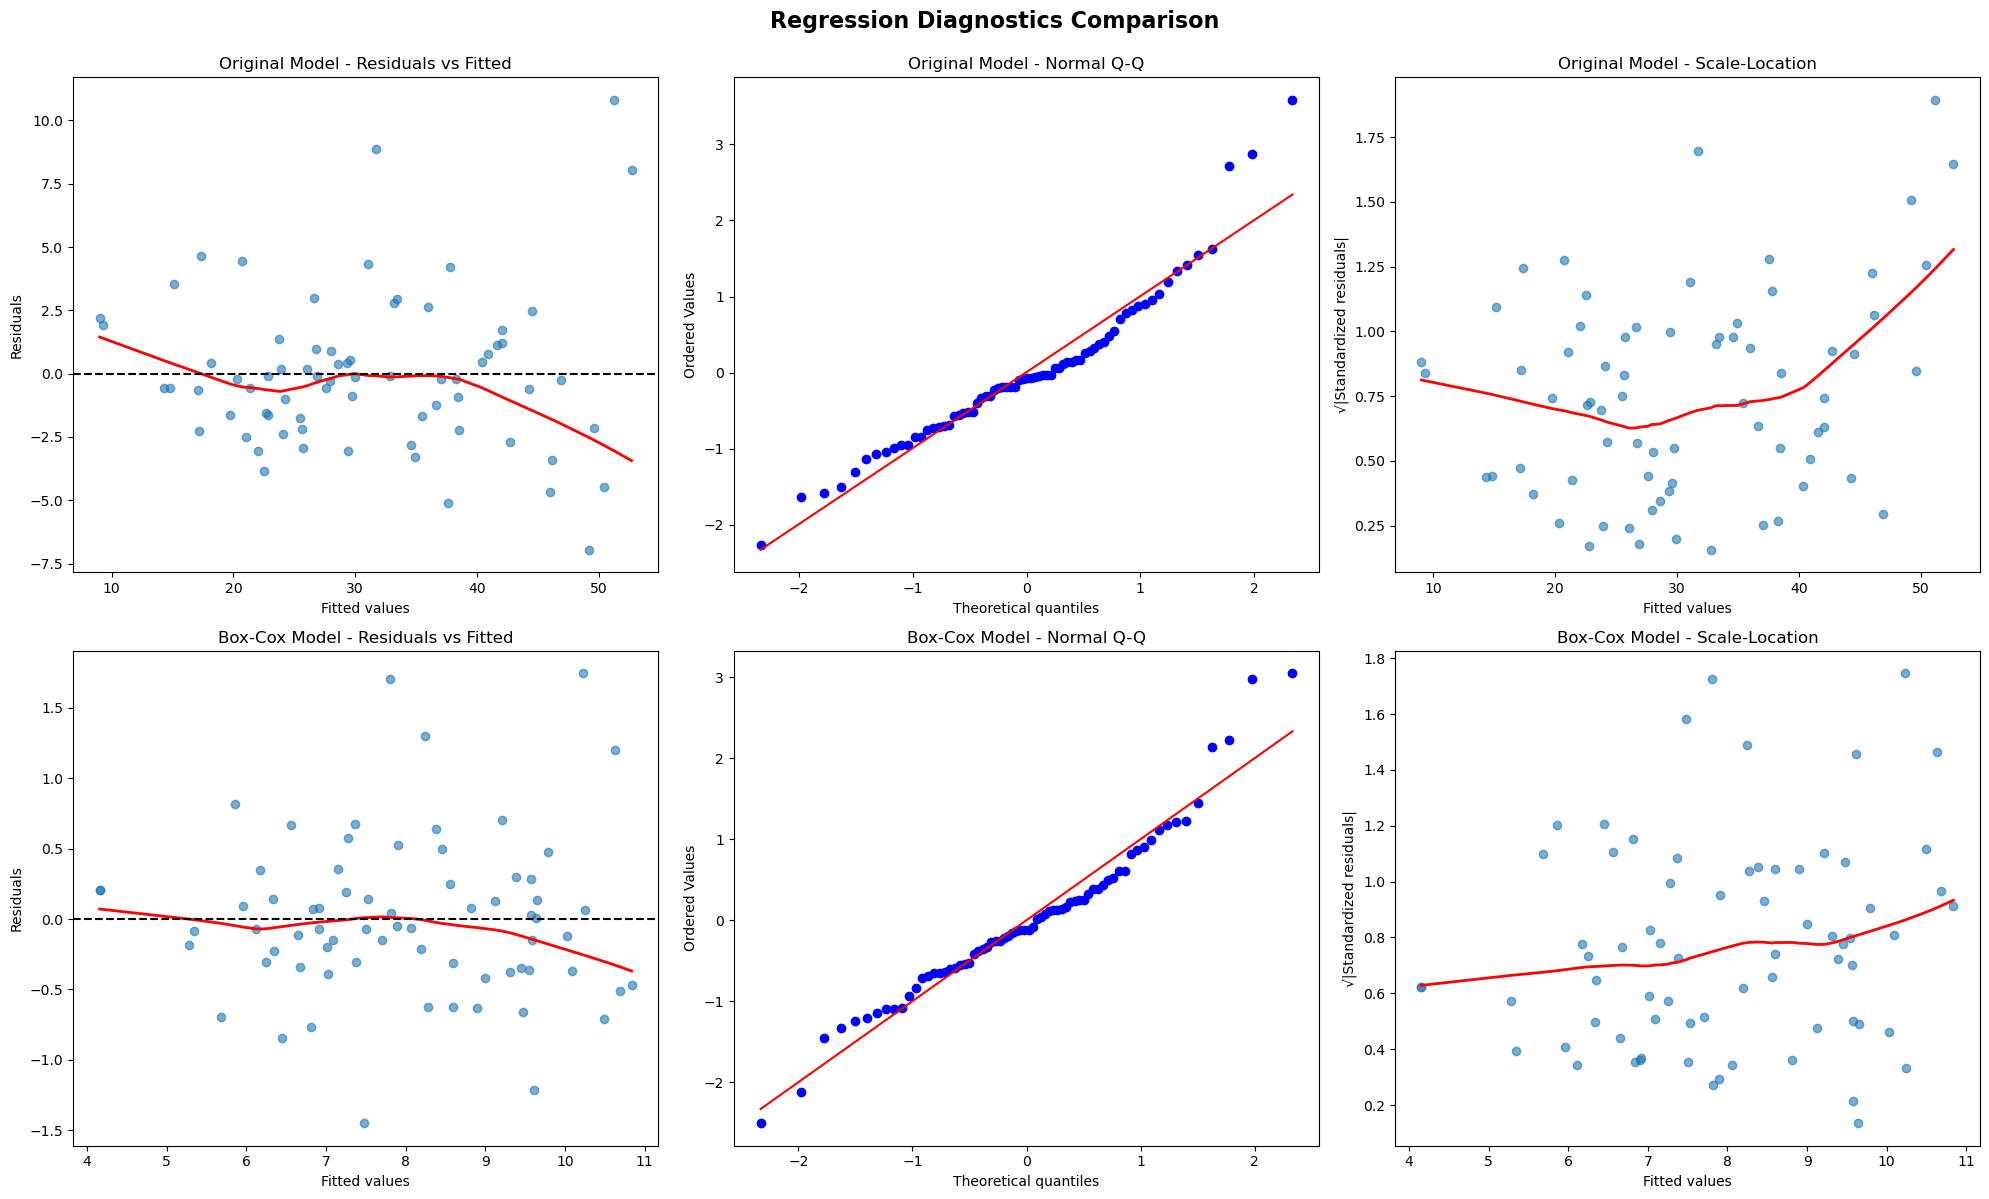

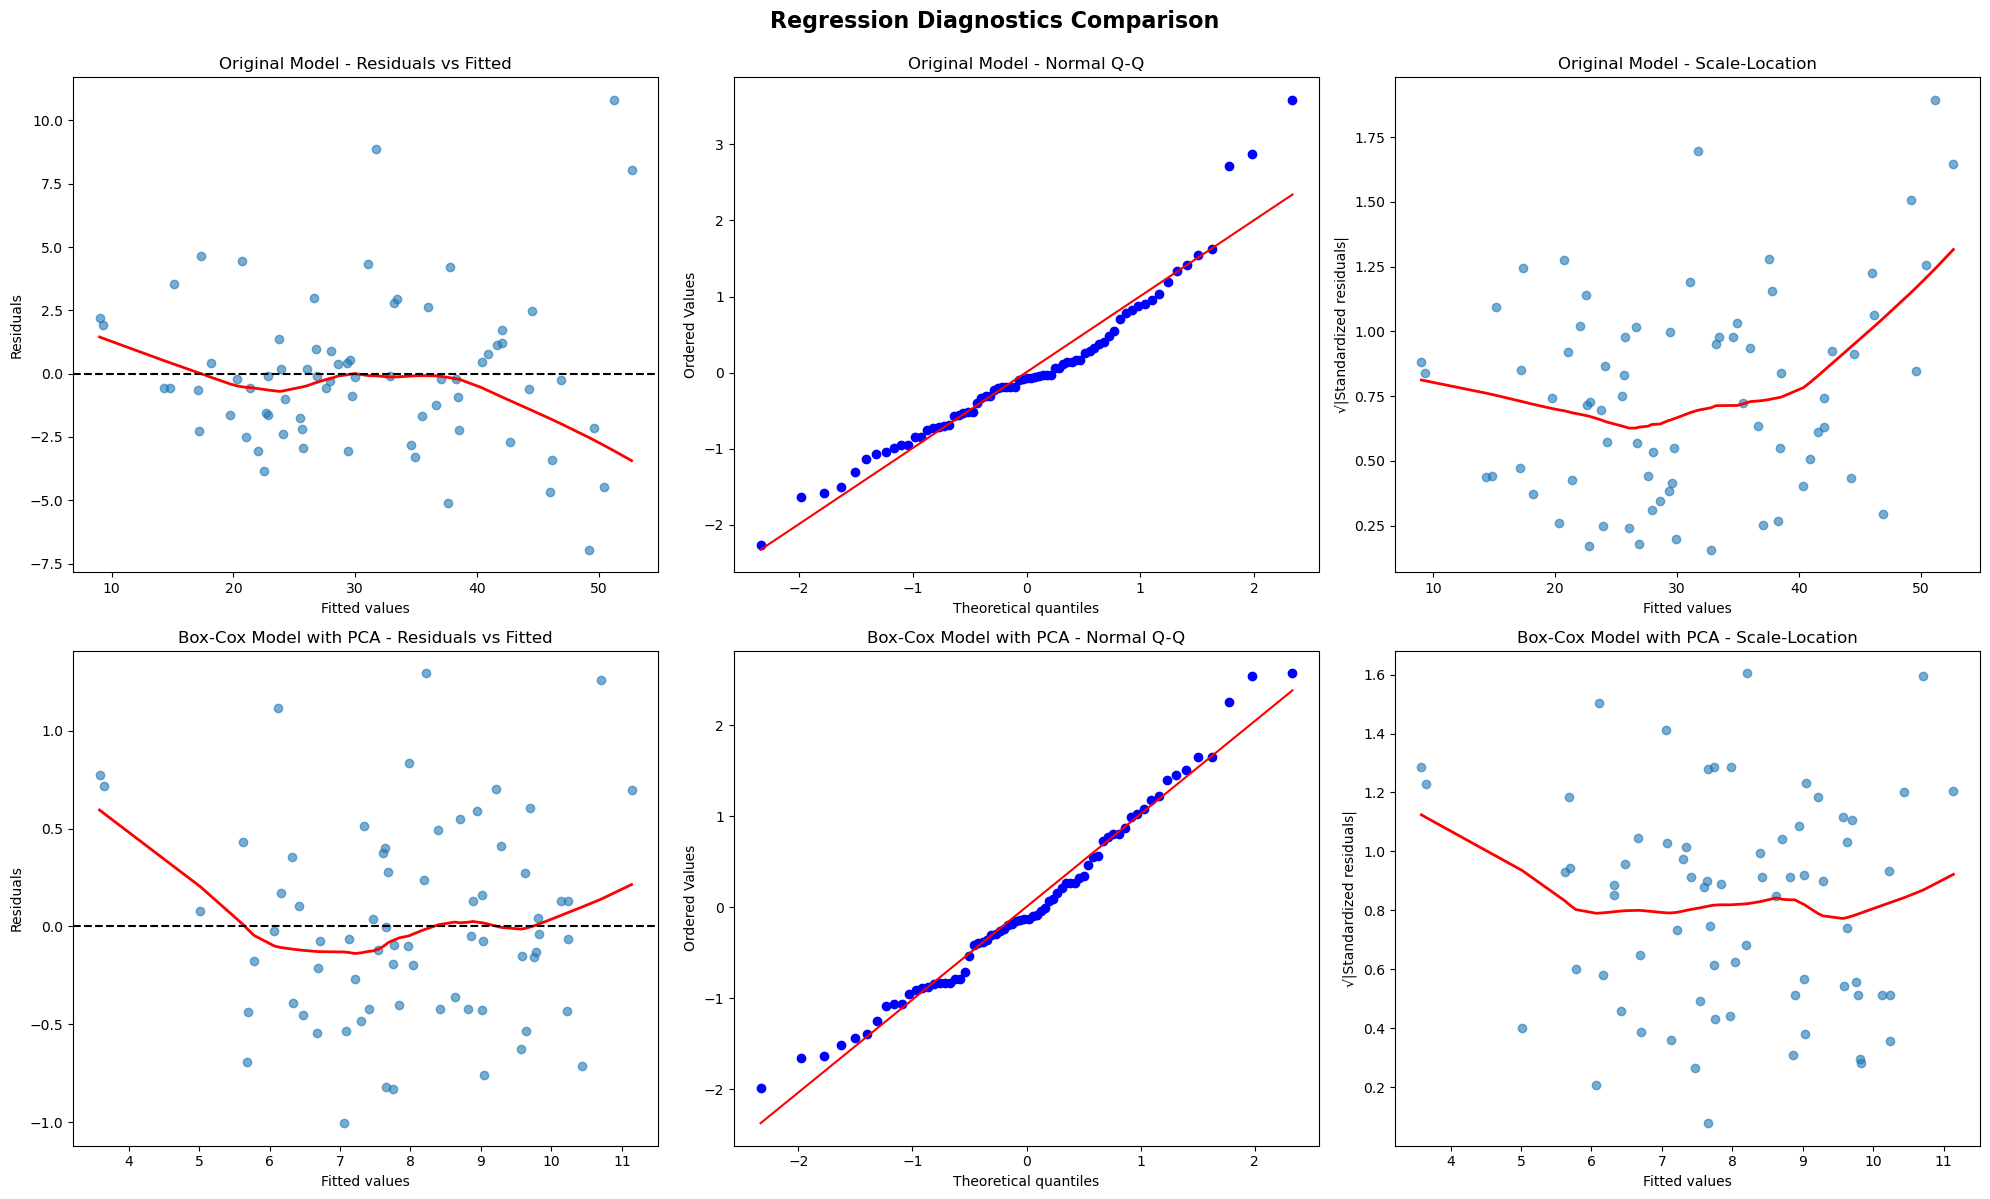

In [499]:
compare_transfo(model_full, model_boxcox, 
                name1='Original Model', 
                name2='Box-Cox Model')

compare_transfo(model_full, model_boxcox_pca, 
                name1='Original Model', 
                name2='Box-Cox Model with PCA')

<b><span style="color:red;">Note: sûrement mieux de les afficher sur meme graphe ?</span></b>


*The Box-Cox transformation with optimal λ = 0.40 showed mixed results. The transformation successfully reduced heteroscedasticity in the middle range of fitted values, particularly flattening the lowess curve for fitted values below 6 in the Scale-Location plot. However, the presence of extreme outliers (points 24, 26, and 40) overwhelms this improvement. This suggests that while Box-Cox addresses the underlying heteroscedasticity pattern in the bulk of the data, it cannot compensate for individual extreme observations that require separate treatment through removal or robust regression methods.*

### Predictor Transformation

Based on bivariate plots and residual analysis, we may consider:
- Log transformation for asymmetric variables
- Polynomials for non-linear relationships
- Interactions between variables

Predictor skewness:
waistcirc       0.365296
elbowbreadth   -0.226947
anthro3c       -1.079842
dtype: float64

Highly asymmetric variables: ['anthro3c']

MODEL WITH TRANSFORMED PREDICTORS
Original R²: 0.8795
R² with transformed X: 0.8762

→ Keep original predictors


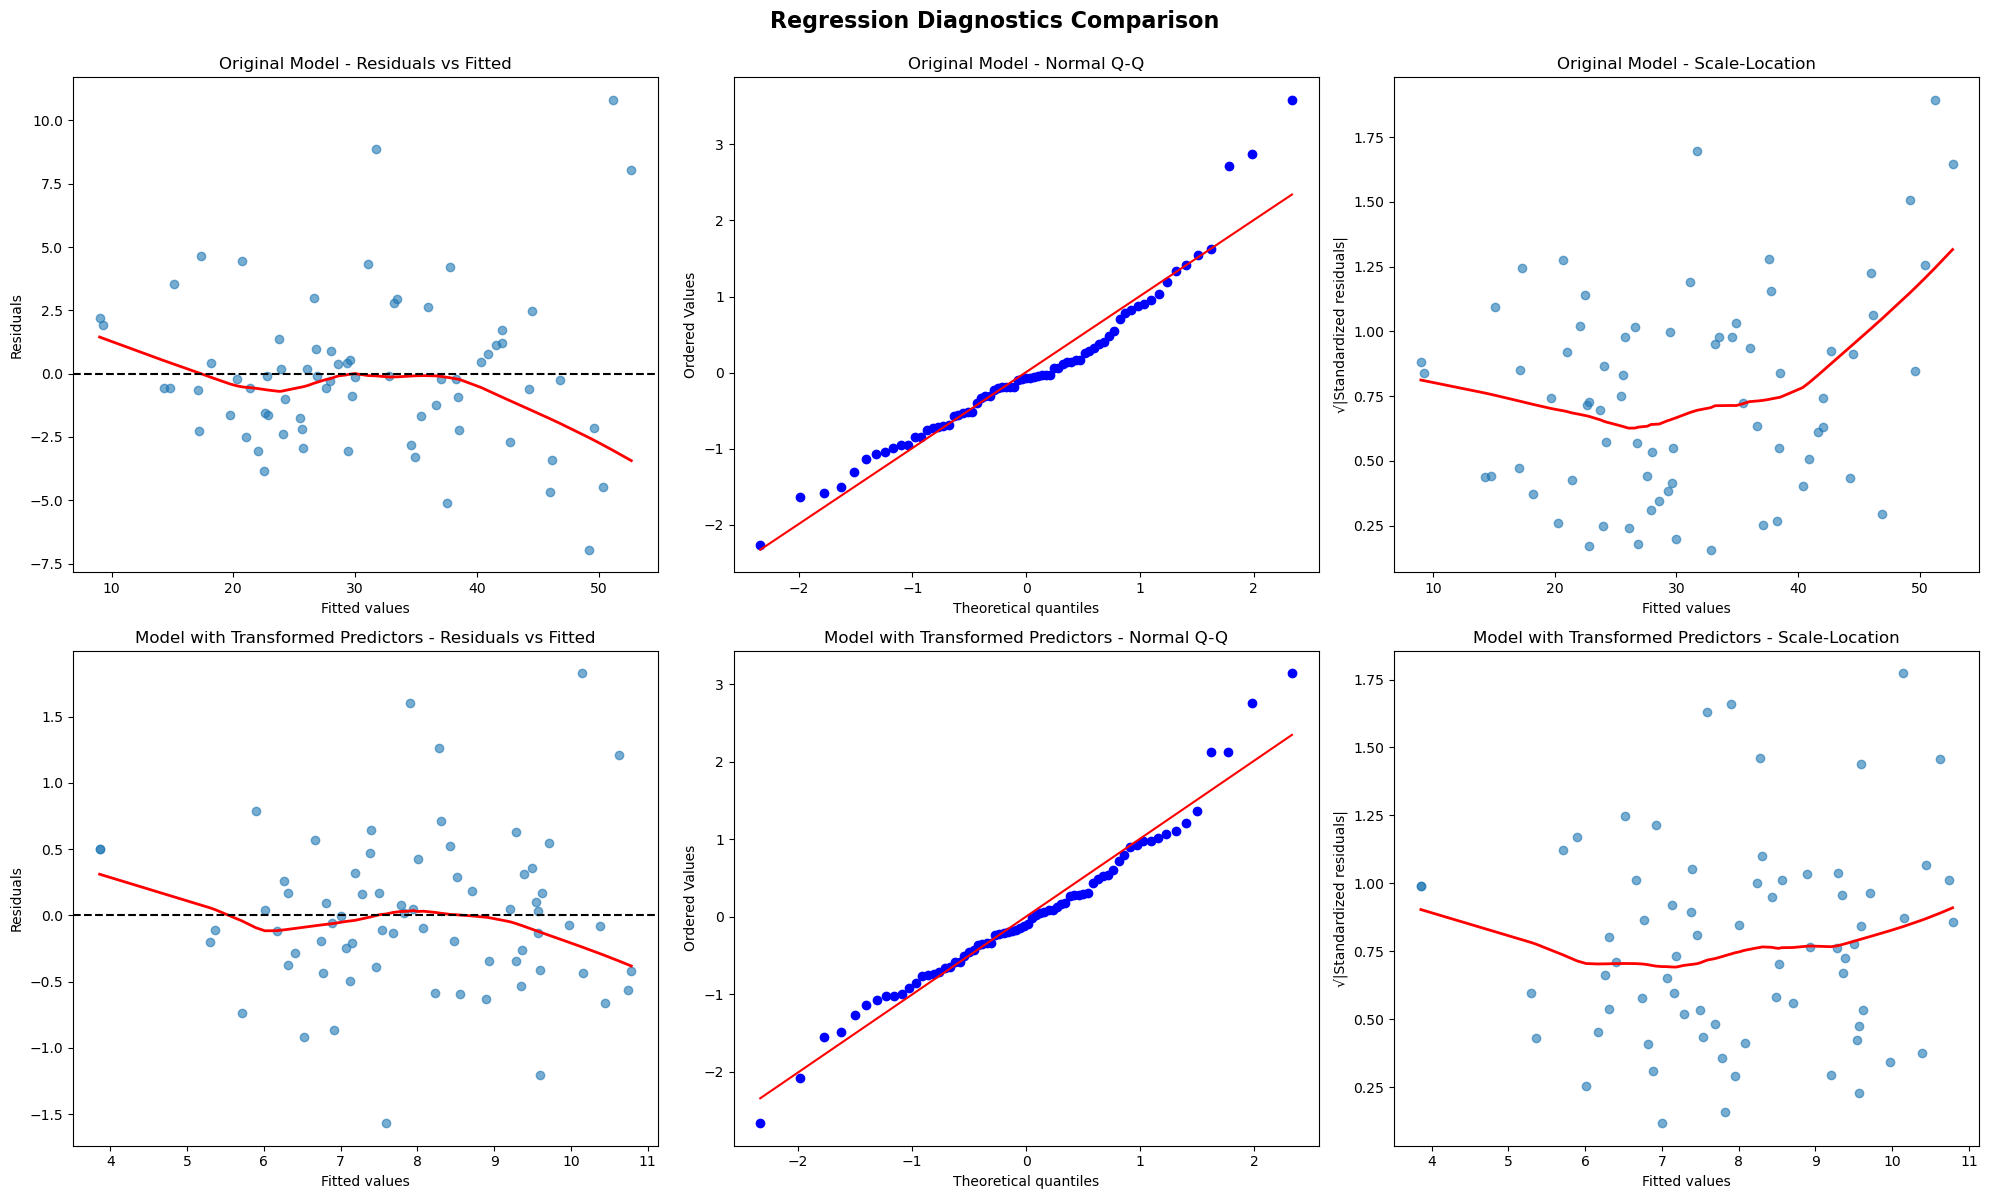

In [500]:
# Example: identify asymmetric variables
from scipy.stats import skew

skewness = X_reduced.apply(lambda x: skew(x))
print("Predictor skewness:")
print(skewness.sort_values(ascending=False))

# Variables with |skewness| > 1 may benefit from transformation
highly_skewed = skewness[abs(skewness) > 1].index.tolist()
print(f"\nHighly asymmetric variables: {highly_skewed}")

# Test log transformation on these variables
if len(highly_skewed) > 0:
    X_transformed = X_reduced.copy()
    
    for var in highly_skewed:
        # Check that all values > 0
        if (X_reduced[var] > 0).all():
            X_transformed[f'{var}_log'] = np.log(X_reduced[var])
            X_transformed = X_transformed.drop(var, axis=1)
    
    # Fit model with transformed X
    X_trans_const = sm.add_constant(X_transformed)
    model_x_trans = sm.OLS(y_transformed, X_trans_const).fit()
    
    print("\n" + "="*60)
    print("MODEL WITH TRANSFORMED PREDICTORS")
    print("="*60)
    print(f"Original R²: {model_boxcox.rsquared_adj:.4f}")
    print(f"R² with transformed X: {model_x_trans.rsquared_adj:.4f}")
    
    if model_x_trans.rsquared_adj > model_boxcox.rsquared_adj:
        print("\n→ Predictor transformation IMPROVES the model")
        model_to_use = model_x_trans
        X_to_use = X_transformed
    else:
        print("\n→ Keep original predictors")
        X_to_use = X_clean
else:
    X_to_use = X_clean

compare_transfo(model_full, model_x_trans, 
                name1='Original Model', name2='Model with Transformed Predictors')

## Variable Selection

We test different selection methods to identify the best subset of predictors.

### 1. All Possible Regressions

Tests all possible combinations (expensive if p > 15).

Running All Possible Regressions...

TOP 5 MODELS - ADJUSTED R²
   n_vars                            variables    R2_adj         AIC  \
4       2                (waistcirc, anthro3c)  0.881296  126.371882   
6       3  (waistcirc, elbowbreadth, anthro3c)  0.879516  128.361160   
0       1                         (waistcirc,)  0.799411  162.132543   
3       2            (waistcirc, elbowbreadth)  0.796946  163.950708   
5       2             (elbowbreadth, anthro3c)  0.744698  179.978763   

          BIC          Cp  
4  133.117368  450.277734  
6  137.355141  444.689663  
0  166.629533  209.987647  
3  170.696194  208.810566  
5  186.724249  139.268547  

TOP 5 MODELS - AIC
   n_vars                            variables    R2_adj         AIC  \
4       2                (waistcirc, anthro3c)  0.881296  126.371882   
6       3  (waistcirc, elbowbreadth, anthro3c)  0.879516  128.361160   
0       1                         (waistcirc,)  0.799411  162.132543   
3       2            (waist

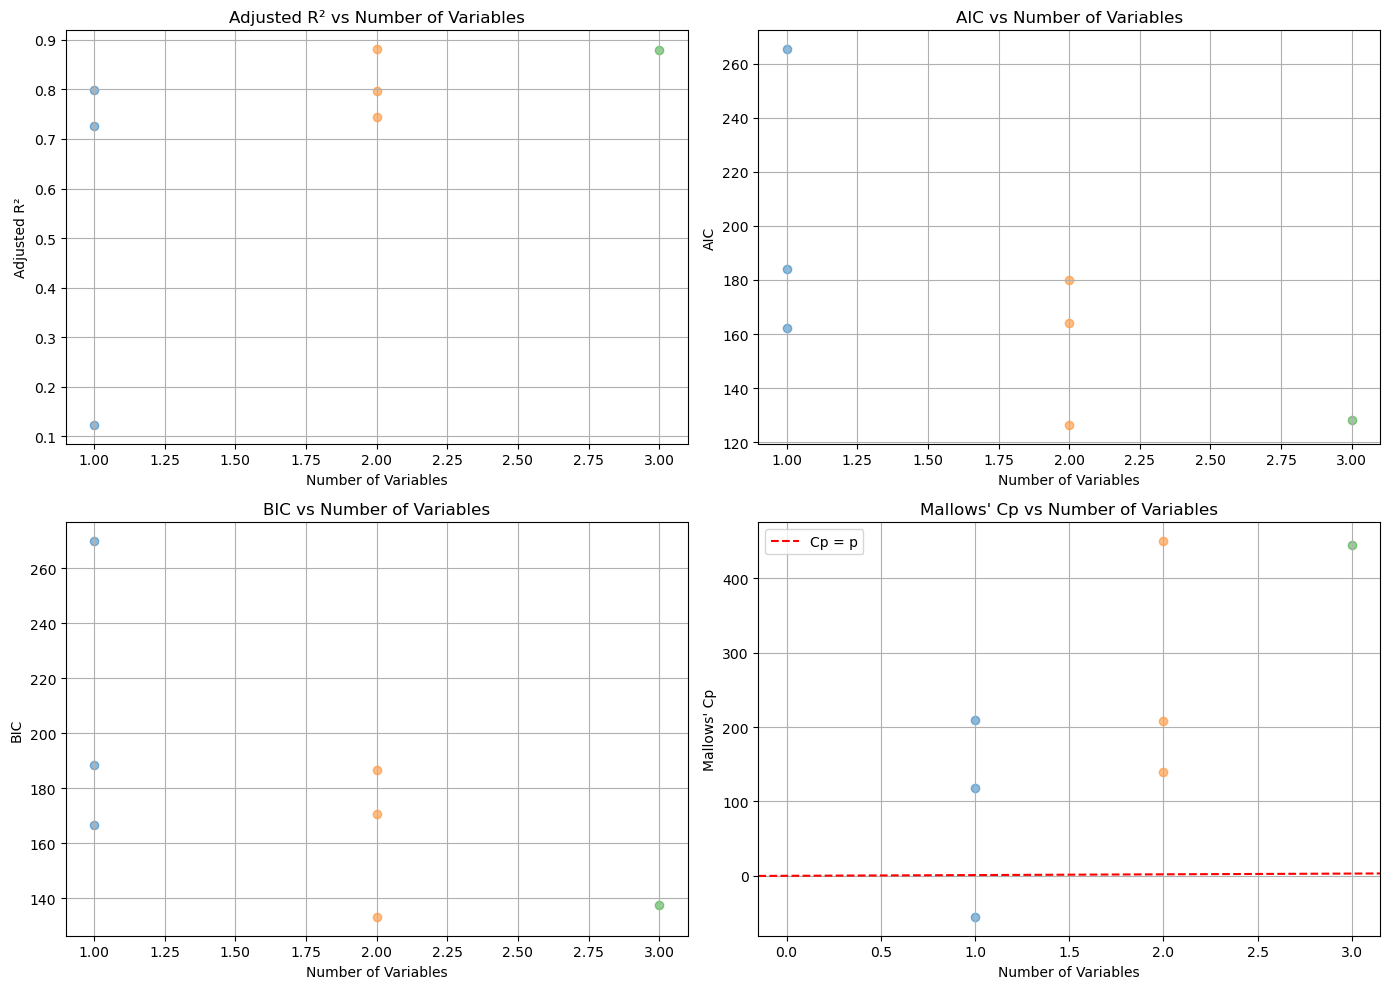

In [509]:
from itertools import combinations
from sklearn.metrics import mean_squared_error

def all_subsets_regression(X, y, metric='aic'):
    """
    Test all combinations of predictors
    """
    results = []
    n_features = X_reduced.shape[1]
    feature_names = X_reduced.columns.tolist()
    
    # Test all combinations from 1 to n_features variables
    for k in range(1, n_features + 1):
        for combo in combinations(feature_names, k):
            X_subset = X[list(combo)]
            X_subset_const = sm.add_constant(X_subset)
            
            model = sm.OLS(y, X_subset_const).fit()
            
            results.append({
                'n_vars': k,
                'variables': combo,
                'R2': model.rsquared,
                'R2_adj': model.rsquared_adj,
                'AIC': model.aic,
                'BIC': model.bic,
                'Cp': model.ess / model.scale - len(y) + 2 * (k + 1)  # Mallows' Cp
            })
    
    return pd.DataFrame(results)

# Execute if reasonable number of variables
print("Running All Possible Regressions...")
all_models = all_subsets_regression(X_reduced, y_transformed)

# Top models by criterion
print("\n" + "="*60)
print("TOP 5 MODELS - ADJUSTED R²")
print("="*60)
print(all_models.nlargest(5, 'R2_adj')[['n_vars', 'variables', 'R2_adj', 'AIC', 'BIC', 'Cp']])

print("\n" + "="*60)
print("TOP 5 MODELS - AIC")
print("="*60)
print(all_models.nsmallest(5, 'AIC')[['n_vars', 'variables', 'R2_adj', 'AIC', 'BIC', 'Cp']])

print("\n" + "="*60)
print("TOP 5 MODELS - BIC")
print("="*60)
print(all_models.nsmallest(5, 'BIC')[['n_vars', 'variables', 'R2_adj', 'AIC', 'BIC', 'Cp']])

print("\n" + "="*60)
print("TOP 5 MODELS - Cp")
print("="*60)
print(all_models.nlargest(5, 'Cp')[['n_vars', 'variables', 'R2_adj', 'AIC', 'BIC', 'Cp']])

# Visualize criteria as function of number of variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for n in range(1, X_reduced.shape[1] + 1):
    subset = all_models[all_models['n_vars'] == n]
    
    axes[0, 0].scatter([n] * len(subset), subset['R2_adj'], alpha=0.5)
    axes[0, 1].scatter([n] * len(subset), subset['AIC'], alpha=0.5)
    axes[1, 0].scatter([n] * len(subset), subset['BIC'], alpha=0.5)
    axes[1, 1].scatter([n] * len(subset), subset['Cp'], alpha=0.5)

axes[0, 0].set_xlabel('Number of Variables')
axes[0, 0].set_ylabel('Adjusted R²')
axes[0, 0].set_title('Adjusted R² vs Number of Variables')
axes[0, 0].grid(True)

axes[0, 1].set_xlabel('Number of Variables')
axes[0, 1].set_ylabel('AIC')
axes[0, 1].set_title('AIC vs Number of Variables')
axes[0, 1].grid(True)

axes[1, 0].set_xlabel('Number of Variables')
axes[1, 0].set_ylabel('BIC')
axes[1, 0].set_title('BIC vs Number of Variables')
axes[1, 0].grid(True)

axes[1, 1].set_xlabel('Number of Variables')
axes[1, 1].set_ylabel("Mallows' Cp")
axes[1, 1].set_title("Mallows' Cp vs Number of Variables")
axes[1, 1].axline((0, 0), slope=1, color='r', linestyle='--', label='Cp = p')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [502]:
def forward_selection(X, y, criterion='aic'):
    """
    Forward selection based on AIC/BIC
    """
    initial_features = []
    remaining_features = list(X_reduced.columns)
    best_scores = []
    
    while remaining_features:
        scores_with_candidates = []
        
        for candidate in remaining_features:
            features = initial_features + [candidate]
            X_subset = X_reduced[features]
            X_subset_const = sm.add_constant(X_subset)
            
            model = sm.OLS(y, X_subset_const).fit()
            
            score = model.aic if criterion == 'aic' else model.bic
            scores_with_candidates.append((score, candidate))
        
        scores_with_candidates.sort()
        best_score, best_candidate = scores_with_candidates[0]
        
        # Check if addition improves criterion
        if not best_scores or best_score < min(best_scores):
            initial_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            best_scores.append(best_score)
            print(f"Adding '{best_candidate}' - {criterion.upper()} = {best_score:.2f}")
        else:
            break
    
    return initial_features

print("="*60)
print("FORWARD SELECTION (AIC)")
print("="*60)
forward_vars_aic = forward_selection(X_reduced, y_transformed, criterion='aic')
print(f"\nSelected variables: {forward_vars_aic}")

# Fit final forward model
X_forward = X_reduced[forward_vars_aic]
X_forward_const = sm.add_constant(X_forward)
model_forward = sm.OLS(y_transformed, X_forward_const).fit()

print("\n" + "="*60)
print("FORWARD SELECTION MODEL")
print("="*60)
print(model_forward.summary())

print(X_reduced.columns)

FORWARD SELECTION (AIC)
Adding 'waistcirc' - AIC = 162.13
Adding 'anthro3c' - AIC = 126.37

Selected variables: ['waistcirc', 'anthro3c']

FORWARD SELECTION MODEL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     257.1
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           3.69e-32
Time:                        23:12:24   Log-Likelihood:                -60.186
No. Observations:                  70   AIC:                             126.4
Df Residuals:                      67   BIC:                             133.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

In [503]:
def backward_elimination(X, y, criterion='aic', threshold_out=0.05):
    """
    Backward elimination based on AIC/BIC or p-values
    """
    features = list(X.columns)
    
    while len(features) > 0:
        X_subset = X[features]
        X_subset_const = sm.add_constant(X_subset)
        
        model = sm.OLS(y, X_subset_const).fit()
        
        # Criterion based on p-values
        if criterion == 'pvalue':
            max_pvalue = model.pvalues[1:].max()  # Exclude intercept
            if max_pvalue > threshold_out:
                worst_feature = model.pvalues[1:].idxmax()
                features.remove(worst_feature)
                print(f"Removing '{worst_feature}' (p-value = {max_pvalue:.4f})")
            else:
                break
        # Criterion based on AIC/BIC
        else:
            # Test removal of each variable
            scores = []
            for feature in features:
                temp_features = [f for f in features if f != feature]
                if len(temp_features) > 0:
                    X_temp = X[temp_features]
                    X_temp_const = sm.add_constant(X_temp)
                    model_temp = sm.OLS(y, X_temp_const).fit()
                    score = model_temp.aic if criterion == 'aic' else model_temp.bic
                    scores.append((score, feature))
            
            current_score = model.aic if criterion == 'aic' else model.bic
            scores.sort()
            
            if scores and scores[0][0] < current_score:
                best_score, worst_feature = scores[0]
                features.remove(worst_feature)
                print(f"Removing '{worst_feature}' - {criterion.upper()} = {best_score:.2f}")
            else:
                break
    
    return features

print("\n" + "="*60)
print("BACKWARD ELIMINATION (AIC)")
print("="*60)
backward_vars_aic = backward_elimination(X_reduced, y_transformed, criterion='aic')
print(f"\nRetained variables: {backward_vars_aic}")

# Fit final backward model
X_backward = X_reduced[backward_vars_aic]
X_backward_const = sm.add_constant(X_backward)
model_backward = sm.OLS(y_transformed, X_backward_const).fit()

print("\n" + "="*60)
print("BACKWARD ELIMINATION MODEL")
print("="*60)
print(model_backward.summary())


BACKWARD ELIMINATION (AIC)
Removing 'elbowbreadth' - AIC = 126.37

Retained variables: ['waistcirc', 'anthro3c']

BACKWARD ELIMINATION MODEL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     257.1
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           3.69e-32
Time:                        23:12:24   Log-Likelihood:                -60.186
No. Observations:                  70   AIC:                             126.4
Df Residuals:                      67   BIC:                             133.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025  

In [504]:
def stepwise_selection(X, y, criterion='aic', threshold_in=0.01, threshold_out=0.05):
    """
    Stepwise selection combining forward and backward
    """
    initial_features = []
    
    while True:
        changed = False
        
        # Forward step
        remaining_features = [f for f in X.columns if f not in initial_features]
        
        if remaining_features:
            best_pval = 1.0
            best_feature = None
            
            for candidate in remaining_features:
                features = initial_features + [candidate]
                X_subset = X[features]
                X_subset_const = sm.add_constant(X_subset)
                model = sm.OLS(y, X_subset_const).fit()
                pval = model.pvalues[candidate]
                
                if pval < best_pval:
                    best_pval = pval
                    best_feature = candidate
            
            if best_pval < threshold_in:
                initial_features.append(best_feature)
                changed = True
                print(f"Adding '{best_feature}' (p-value = {best_pval:.4f})")
        
        # Backward step
        if len(initial_features) > 0:
            X_subset = X[initial_features]
            X_subset_const = sm.add_constant(X_subset)
            model = sm.OLS(y, X_subset_const).fit()
            
            pvalues = model.pvalues[1:]  # Exclude intercept
            worst_pval = pvalues.max()
            
            if worst_pval > threshold_out:
                worst_feature = pvalues.idxmax()
                initial_features.remove(worst_feature)
                changed = True
                print(f"Removing '{worst_feature}' (p-value = {worst_pval:.4f})")
        
        if not changed:
            break
    
    return initial_features

print("\n" + "="*60)
print("STEPWISE SELECTION")
print("="*60)
stepwise_vars = stepwise_selection(X_reduced, y_transformed)
print(f"\nSelected variables: {stepwise_vars}")

# Fit final stepwise model
X_stepwise = X_reduced[stepwise_vars]
X_stepwise_const = sm.add_constant(X_stepwise)
model_stepwise = sm.OLS(y_transformed, X_stepwise_const).fit()

print("\n" + "="*60)
print("STEPWISE SELECTION MODEL")
print("="*60)
print(model_stepwise.summary())


STEPWISE SELECTION
Adding 'waistcirc' (p-value = 0.0000)
Adding 'anthro3c' (p-value = 0.0000)

Selected variables: ['waistcirc', 'anthro3c']

STEPWISE SELECTION MODEL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     257.1
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           3.69e-32
Time:                        23:12:24   Log-Likelihood:                -60.186
No. Observations:                  70   AIC:                             126.4
Df Residuals:                      67   BIC:                             133.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          


for full regressors:

AIC         BIC   Adj_R2    Cp  
379.412515  402.039313  0.91174  10.0  

Selection of the best models for each criterion:

- Best for Cp:('age', 'waistcirc', 'hipcirc', 'elbowbreadth', 'kneebreadth', 'anthro3a', 'anthro3b', 'anthro4')

AIC        BIC    Adj_R2        Cp   Cp_diff  
270.722358  287.74874  0.914262  8.000117  0.000117  

- Best for AIC: (waistcirc, hipcirc, kneebreadth, anthro3a)

AIC        BIC    Adj_R2        Cp   Cp_diff  
190  265.480469  274.93957  0.917544  2.258314  1.741686  

- Best for BIC: (hipcirc, kneebreadth, anthro3a)

 BIC    Adj_R2        Cp   Cp_diff  
 273.317449  0.915554  2.214367  0.785633  

- Best for R squared: ('waistcirc', 'hipcirc', 'kneebreadth', 'anthro3a', 'anthro3b', 'anthro4')

 AIC         BIC    Adj_R2        Cp   Cp_diff  
266.88637  280.129112  0.918071  4.130877  1.869123  

- Best for MSE: (waistcirc, elbowbreadth, kneebreadth, anthro3b)

AIC         BIC    Adj_R2         Cp    Cp_diff  
282.696017  292.155118  0.882832  19.626707  15.626707 





*The selection of the best models varies depending on the evaluation criterion. According to Mallows’ Cp, the most balanced model includes eight variables, achieving a Cp very close to the number of parameters, indicating an optimal tradeoff between complexity and bias. The model with the lowest AIC contains four variables, offering a highly parsimonious yet accurate fit, while the BIC favors an even simpler three-variable model, prioritizing simplicity. The model with the highest adjusted R² includes six variables and explains the most variance, although slightly more complex than the Cp-optimal model. Finally, the model with the lowest test MSE, also using four variables, provides the best predictive performance on unseen data but appears overfitted according to Cp. Overall, each criterion highlights a different balance between model complexity, goodness of fit, and predictive accuracy.*

<b><span style="color:red;">Note: A completer. juste comparer AIC,BIC.. etc jsp demander TA</span></b>



COMPARISON OF SELECTION METHODS
             Method  N_vars        R2    R2_adj         AIC         BIC  \
0        Full Model       9  0.923088  0.911740  379.412515  402.039313   
1  Tranformed Model       3  0.884754  0.879516  128.361160  137.355141   
2           Forward       2  0.884737  0.881296  126.371882  133.117368   
3          Backward       2  0.884737  0.881296  126.371882  133.117368   
4          Stepwise       2  0.884737  0.881296  126.371882  133.117368   

           Cp  
0  682.115500  
1  456.689663  
2  450.277734  
3  450.277734  
4  450.277734  

Best model according to adjusted R²: Full Model


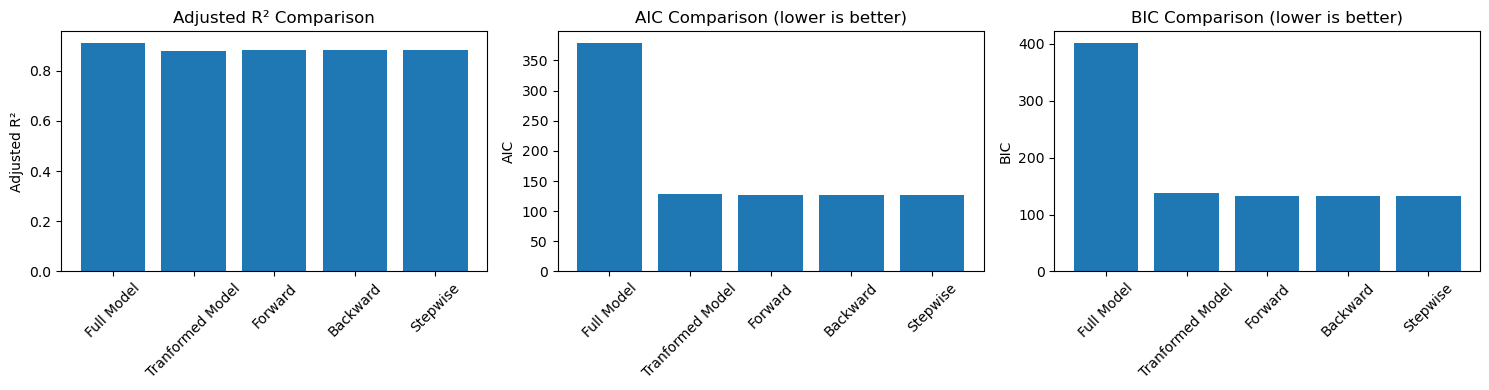

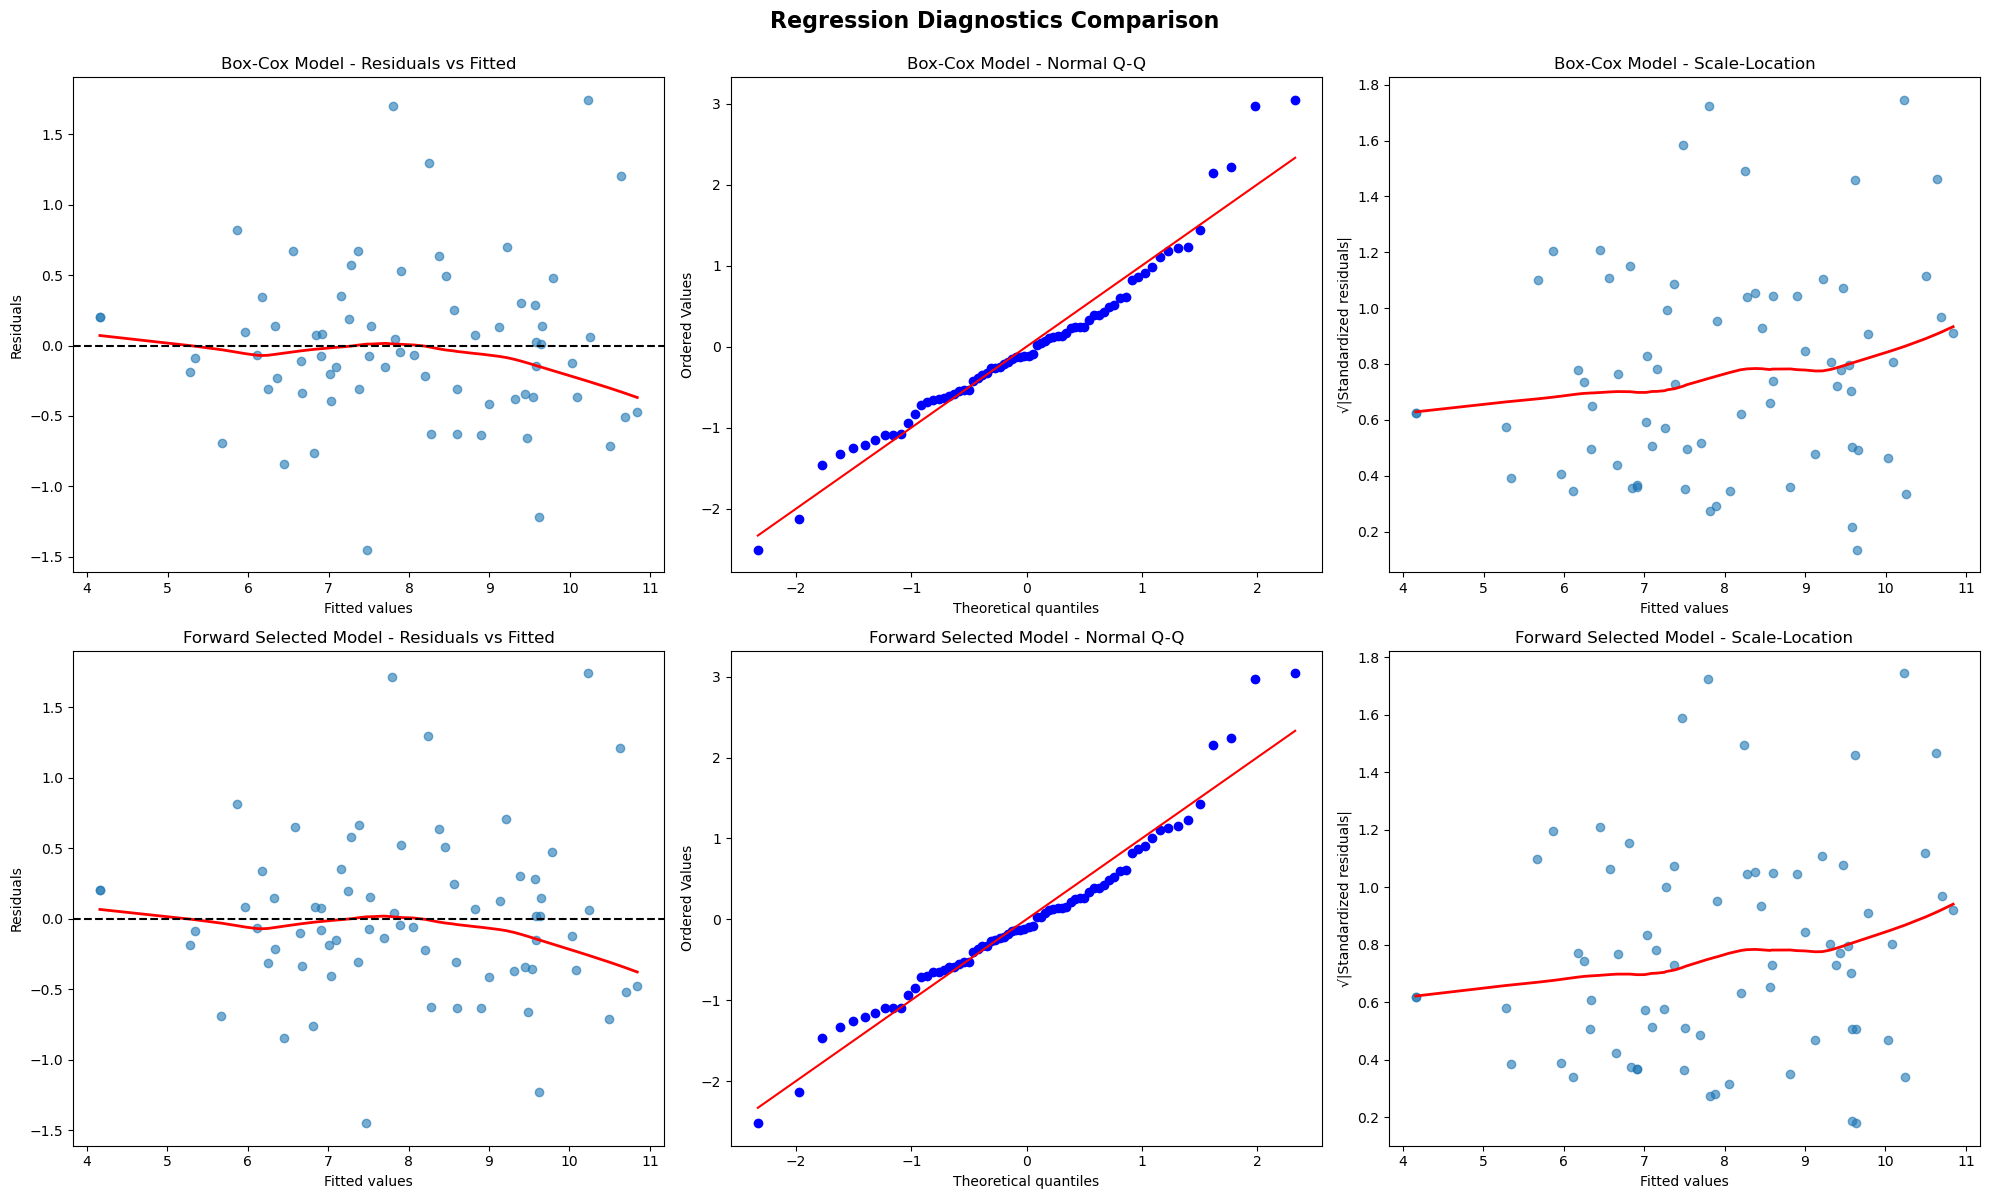

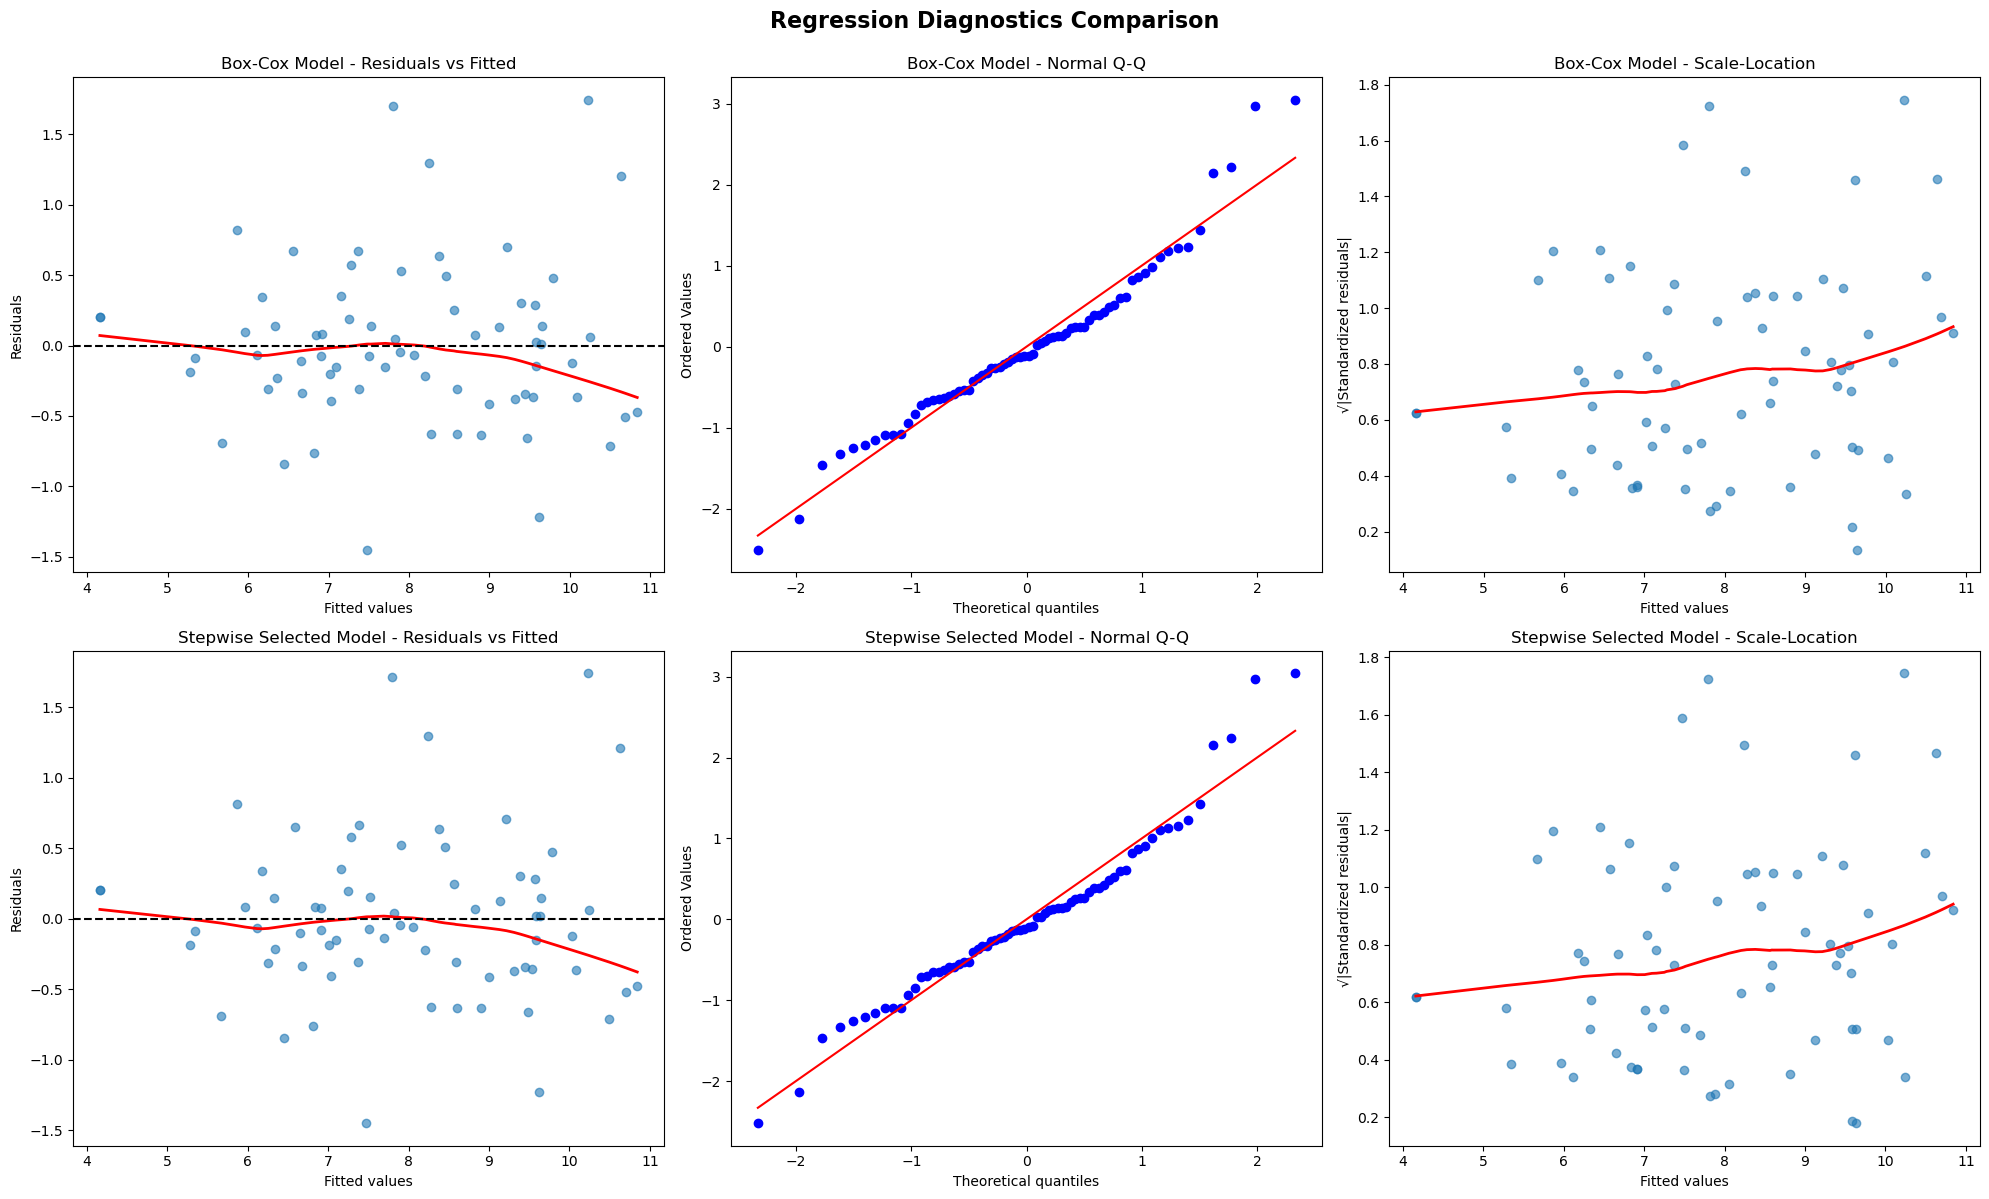

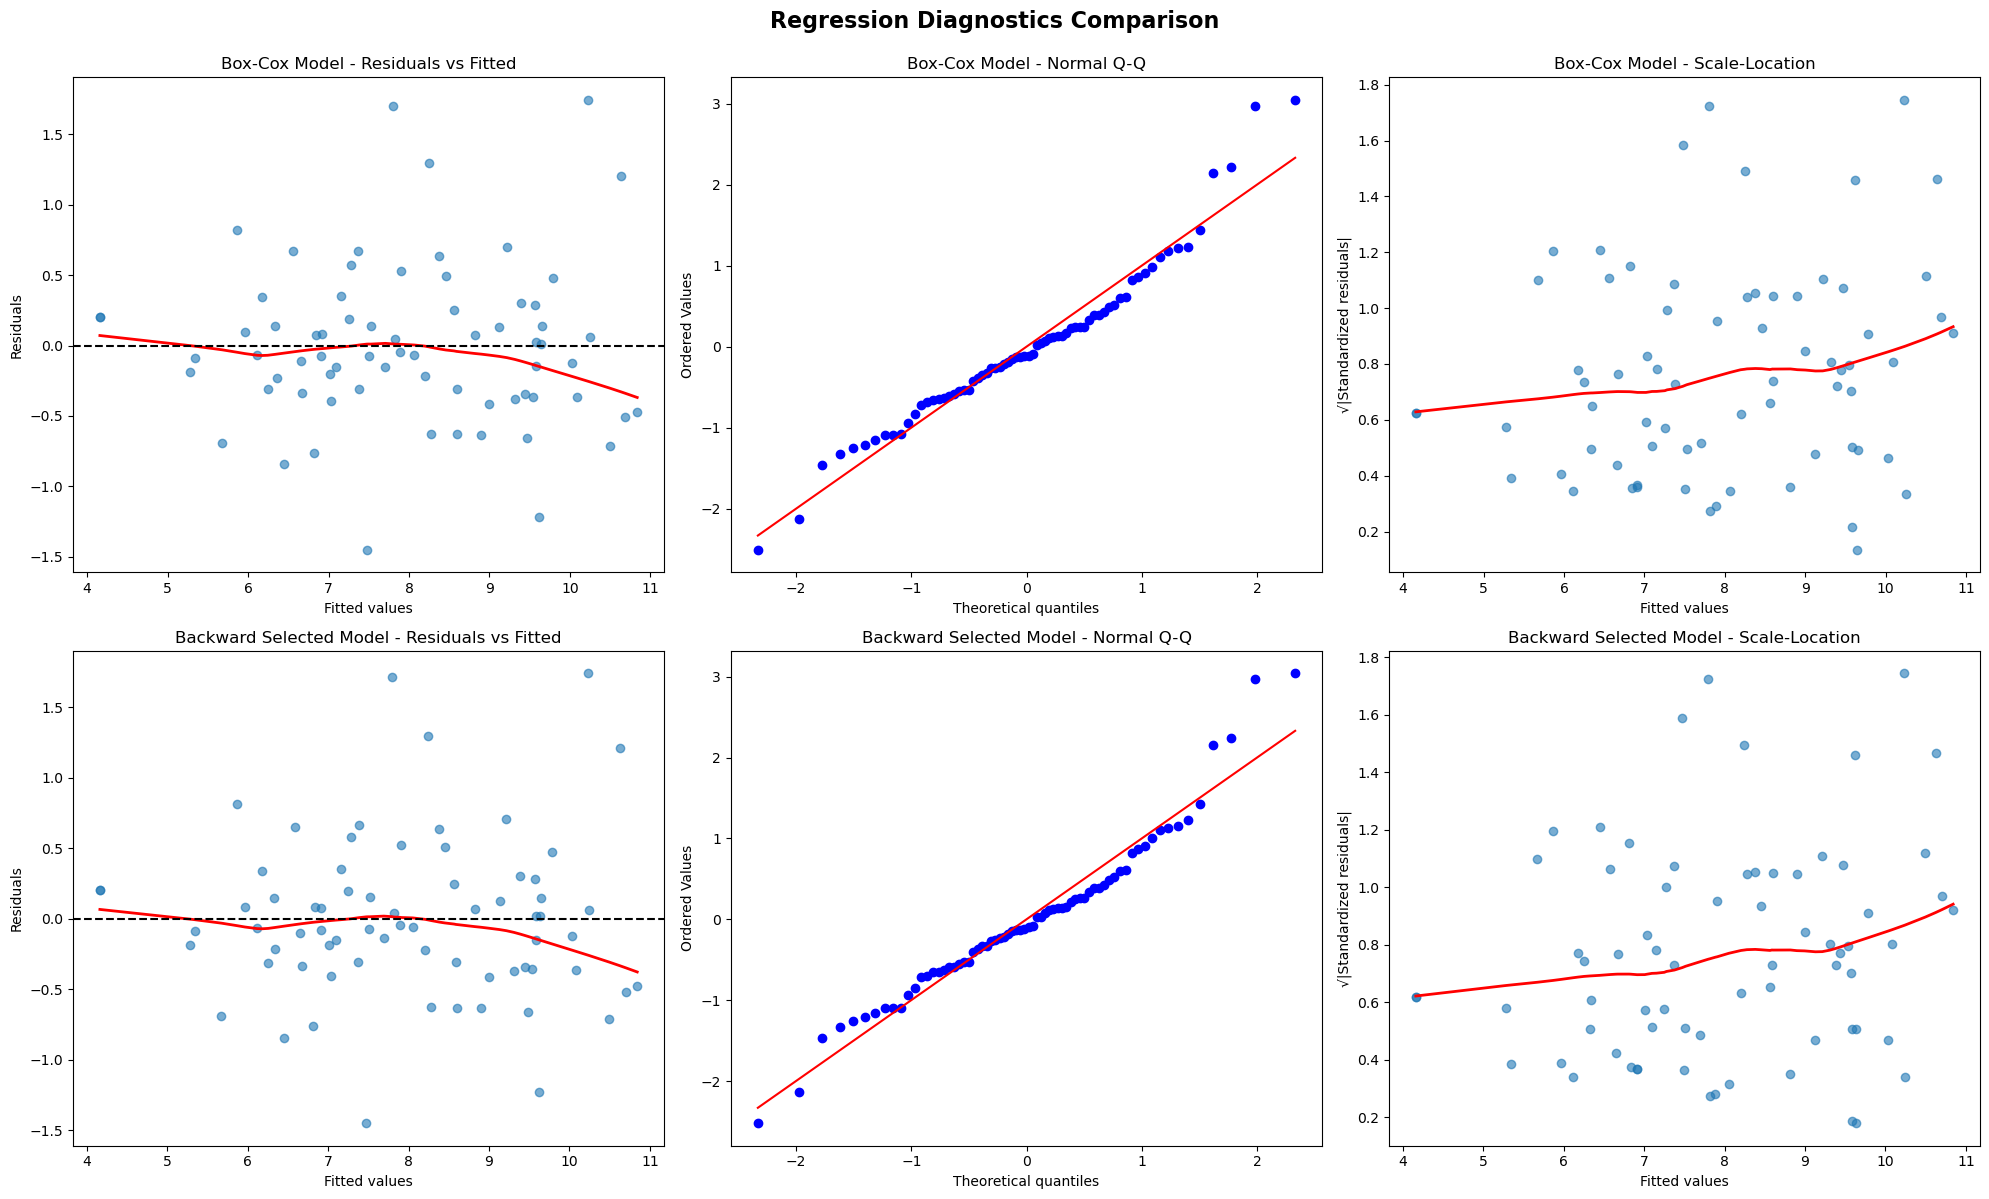

In [514]:
# Comparative summary
methods_comparison = pd.DataFrame({
    'Method': ['Full Model' , 'Tranformed Model', 'Forward', 'Backward', 'Stepwise'],
    'N_vars': [
        len(X.columns),
        len(X_reduced.columns),
        len(forward_vars_aic),
        len(backward_vars_aic),
        len(stepwise_vars)
    ],
    'R2': [
        model_full.rsquared,
        model_boxcox.rsquared,
        model_forward.rsquared,
        model_backward.rsquared,
        model_stepwise.rsquared
    ],
    'R2_adj': [
        model_full.rsquared_adj,
        model_boxcox.rsquared_adj,
        model_forward.rsquared_adj,
        model_backward.rsquared_adj,
        model_stepwise.rsquared_adj
    ],
    'AIC': [
        model_full.aic,
        model_boxcox.aic,
        model_forward.aic,
        model_backward.aic,
        model_stepwise.aic
    ],
    'BIC': [
        model_full.bic,
        model_boxcox.bic,
        model_forward.bic,
        model_backward.bic,
        model_stepwise.bic
    ],
    'Cp': [
        model_full.ess / model_full.scale - len(y) + 2 * (k + 1) ,
        model_boxcox.ess / model_boxcox.scale - len(y) + 2 * (k + 1) ,
        model_forward.ess / model_forward.scale - len(y) + 2 * (len(forward_vars_aic) + 1) ,
        model_backward.ess / model_backward.scale - len(y) + 2 * (len(backward_vars_aic) + 1) ,
        model_stepwise.ess / model_stepwise.scale - len(y) + 2 * (len(stepwise_vars) + 1)
    ]
})

print("\n" + "="*60)
print("COMPARISON OF SELECTION METHODS")
print("="*60)
print(methods_comparison)

# Identify best model (e.g., best adjusted R²)
best_method = methods_comparison.loc[methods_comparison['R2_adj'].idxmax(), 'Method']
print(f"\nBest model according to adjusted R²: {best_method}")

# Comparative visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].bar(methods_comparison['Method'], methods_comparison['R2_adj'])
axes[0].set_ylabel('Adjusted R²')
axes[0].set_title('Adjusted R² Comparison')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(methods_comparison['Method'], methods_comparison['AIC'])
axes[1].set_ylabel('AIC')
axes[1].set_title('AIC Comparison (lower is better)')
axes[1].tick_params(axis='x', rotation=45)

axes[2].bar(methods_comparison['Method'], methods_comparison['BIC'])
axes[2].set_ylabel('BIC')
axes[2].set_title('BIC Comparison (lower is better)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


compare_transfo(model_boxcox, model_forward, 
                name1='Box-Cox Model', name2='Forward Selected Model')
compare_transfo(model_boxcox, model_stepwise,
                name1='Box-Cox Model', name2='Stepwise Selected Model')
compare_transfo(model_boxcox, model_backward, 
                name1='Box-Cox Model', name2='Backward Selected Model')


### 6) Perform a thorough analysis of the “ best ” models (usually three to fi ve models).


ANALYSIS: Best Model after All Subsets
Variables: ['waistcirc', 'anthro3c']

Model Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     257.1
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           3.69e-32
Time:                        23:39:52   Log-Likelihood:                -60.186
No. Observations:                  70   AIC:                             126.4
Df Residuals:                      67   BIC:                             133.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

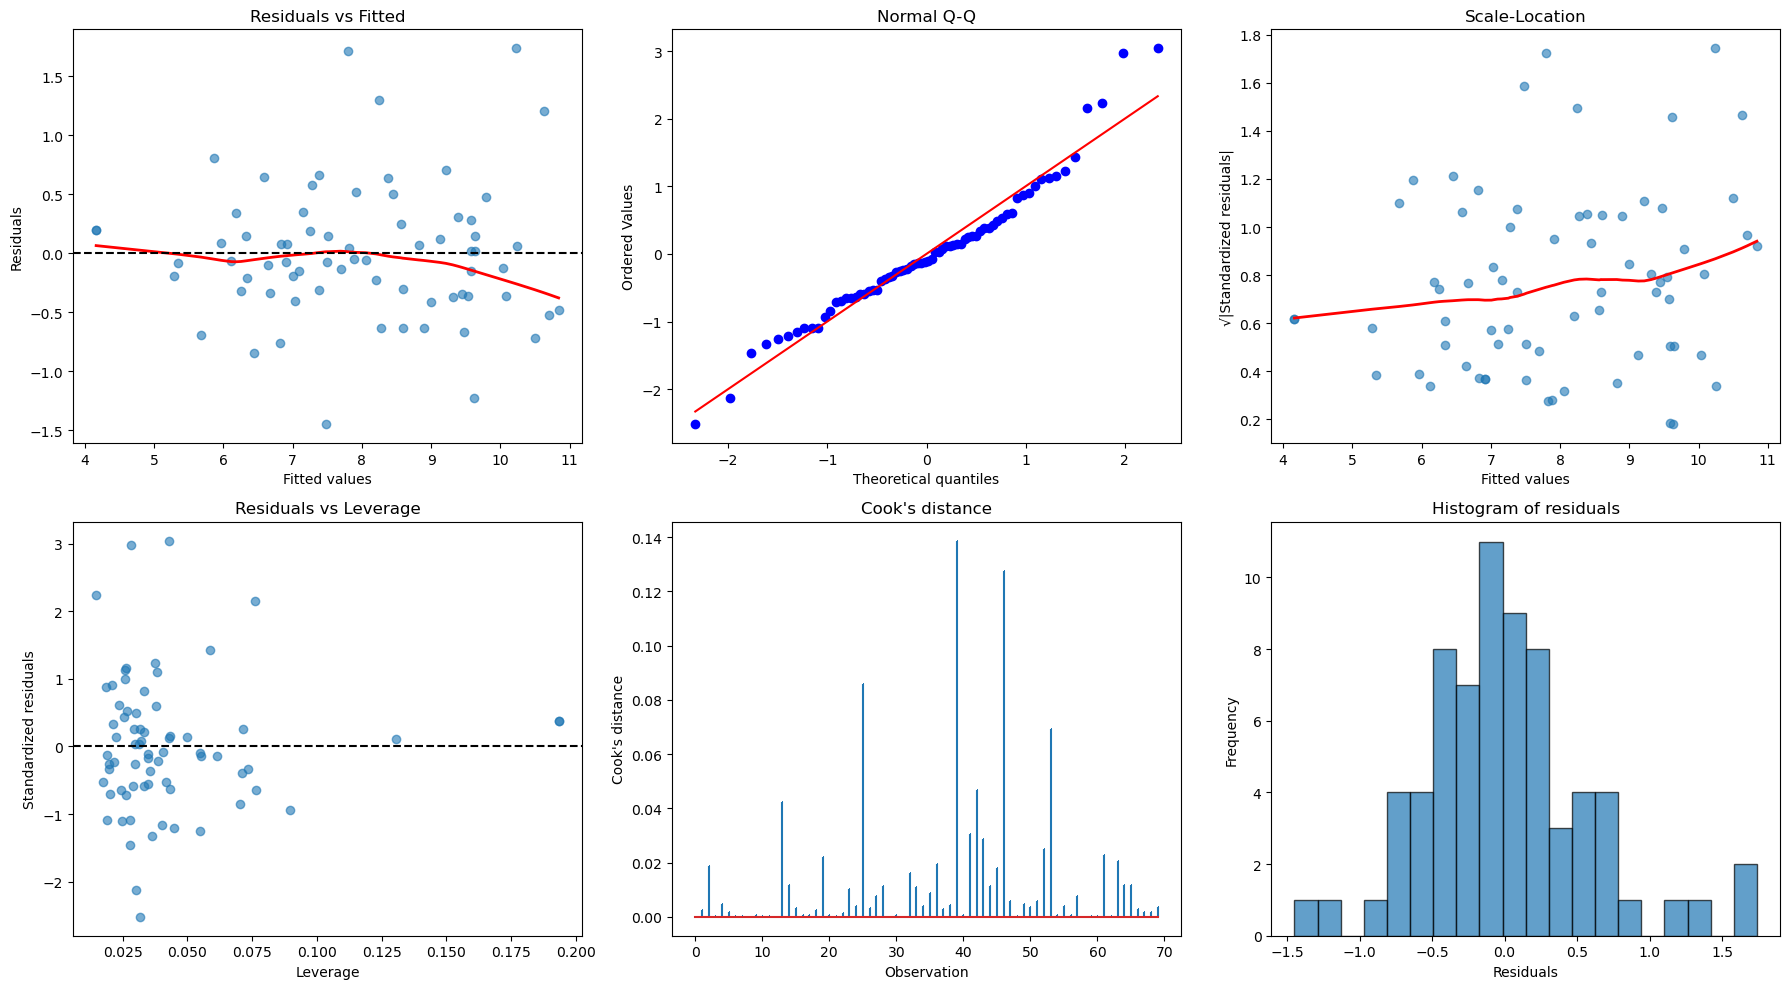


--- MONTGOMERY CRITICAL QUESTIONS ---

1. Are diagnostic checks satisfactory?
   - All VIF < 10: False
   - No Cook's outliers: False

2. Does the model make sense?
   - Variables: ['waistcirc', 'anthro3c']
   - All related to body composition: reasonable for BFM prediction

3. Is the model usable?
   - All variables easily measurable: Yes
   - Number of variables: 2 (parsimony)

4. Are coefficients reasonable?
   - Check signs and magnitudes in summary above

5. Multicollinearity resolved?
   - Max VIF: 83.65 (threshold: 10)

ANALYSIS: Second best Model after All Subsets
Variables: ['waistcirc', 'anthro3c', 'elbowbreadth']

Model Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     168.9
Date:                Mon, 09 Feb 20

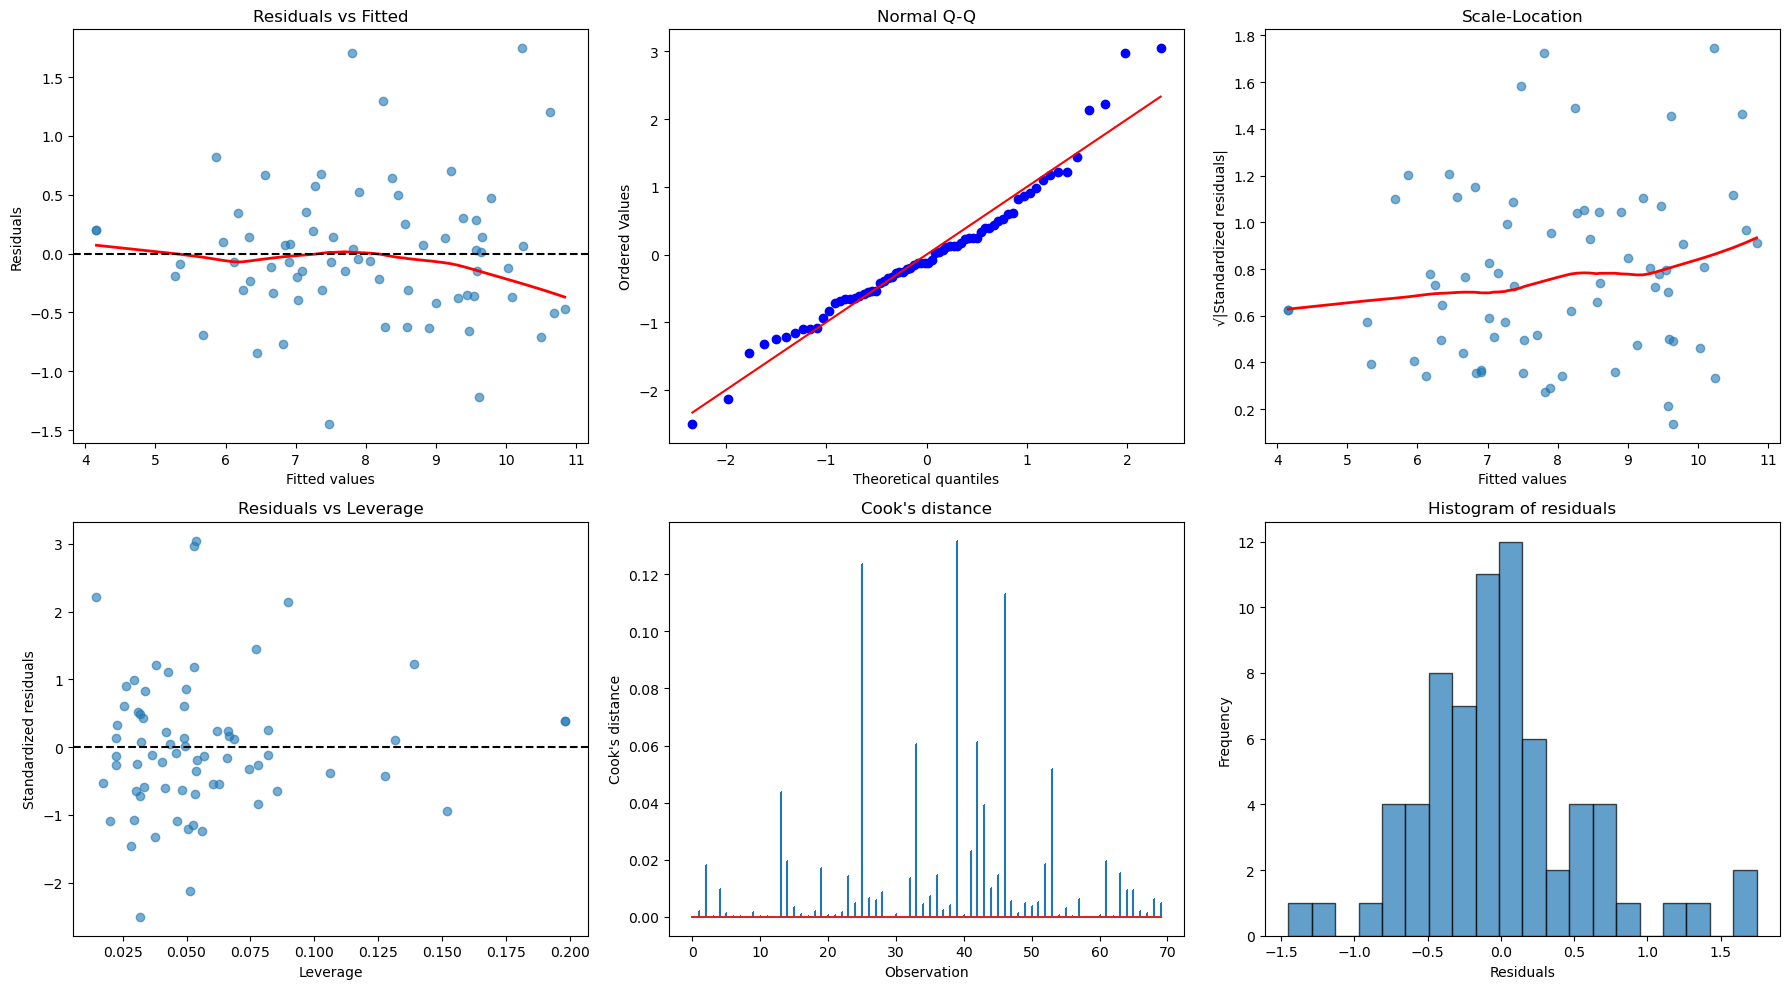


--- MONTGOMERY CRITICAL QUESTIONS ---

1. Are diagnostic checks satisfactory?
   - All VIF < 10: False
   - No Cook's outliers: False

2. Does the model make sense?
   - Variables: ['waistcirc', 'anthro3c', 'elbowbreadth']
   - All related to body composition: reasonable for BFM prediction

3. Is the model usable?
   - All variables easily measurable: Yes
   - Number of variables: 3 (parsimony)

4. Are coefficients reasonable?
   - Check signs and magnitudes in summary above

5. Multicollinearity resolved?
   - Max VIF: 98.19 (threshold: 10)

ANALYSIS: Reduced Model
Variables: ['waistcirc', 'elbowbreadth', 'anthro3c']

Model Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     168.9
Date:                Mon, 09 Feb 2026   P

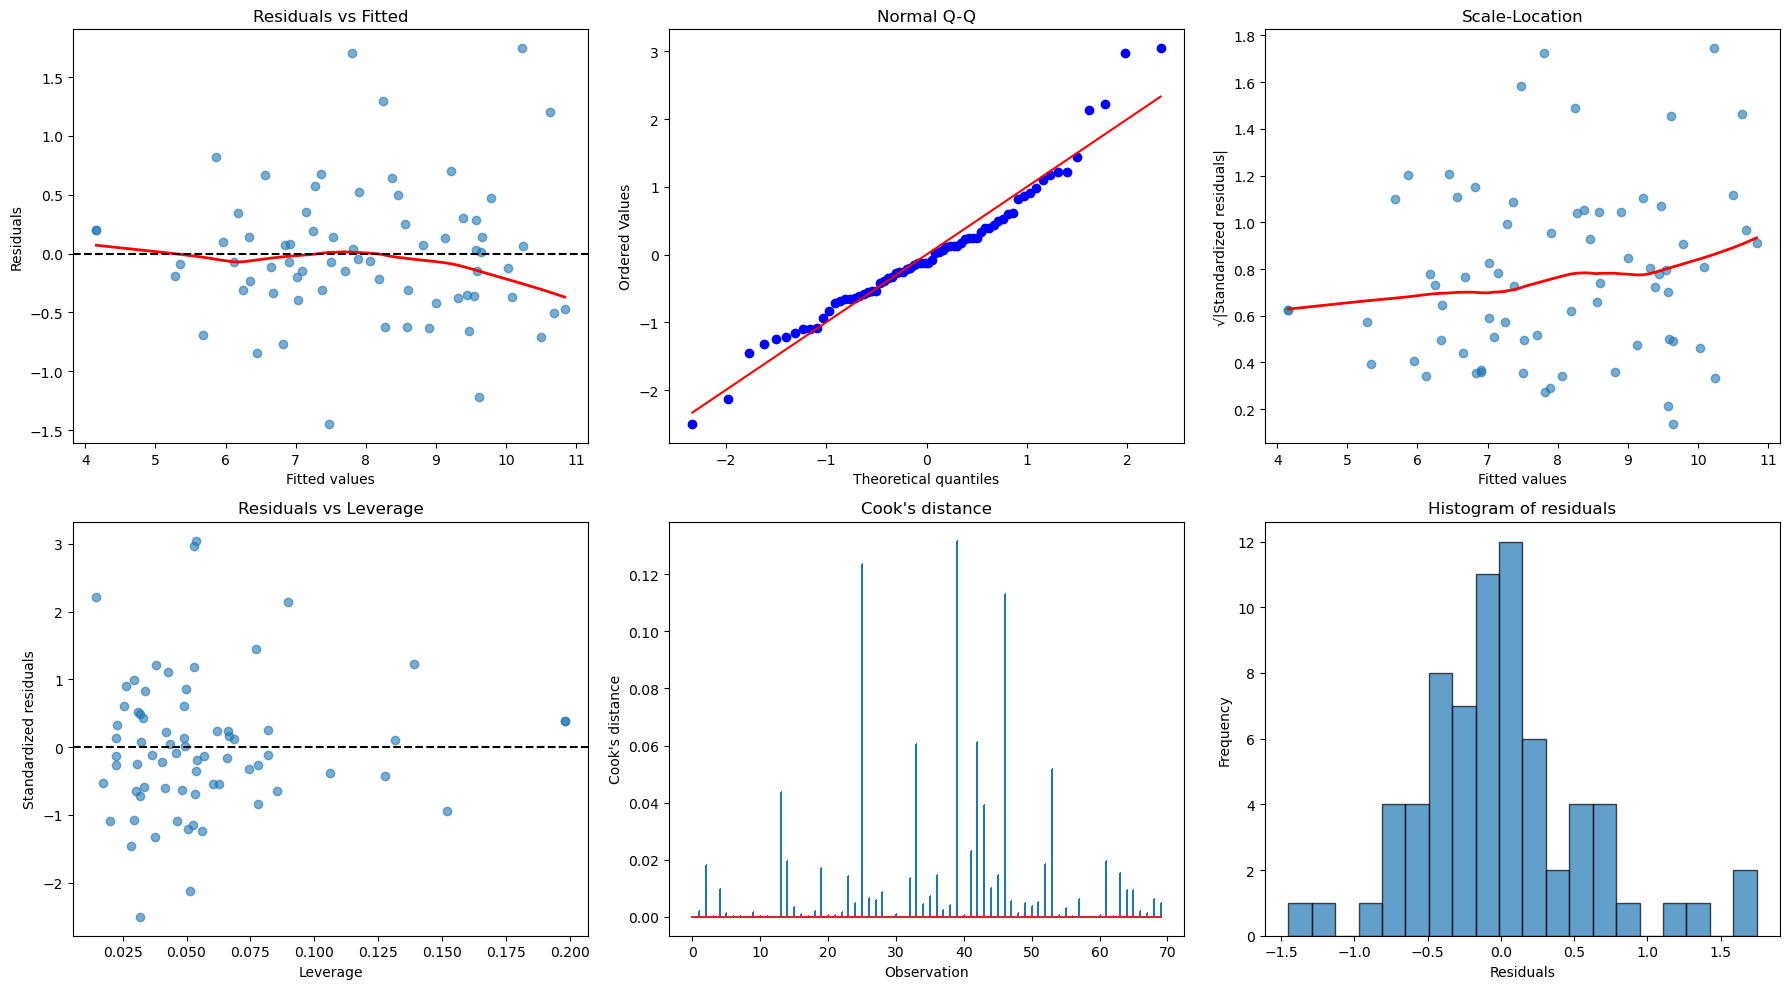


--- MONTGOMERY CRITICAL QUESTIONS ---

1. Are diagnostic checks satisfactory?
   - All VIF < 10: False
   - No Cook's outliers: False

2. Does the model make sense?
   - Variables: ['waistcirc', 'elbowbreadth', 'anthro3c']
   - All related to body composition: reasonable for BFM prediction

3. Is the model usable?
   - All variables easily measurable: Yes
   - Number of variables: 3 (parsimony)

4. Are coefficients reasonable?
   - Check signs and magnitudes in summary above

5. Multicollinearity resolved?
   - Max VIF: 98.19 (threshold: 10)


In [ ]:
candidate_models = [
    {
        'name': 'Best Model after All Subsets',
        'features': ['waistcirc', 'anthro3c'],
        'AIC': 126.37,
        'BIC': 133.12,
        'Adj_R2': 0.881296,
        'Cp': 450.277734  
    },
    {
        'name': 'Second best Model after All Subsets',
        'features': ['waistcirc', 'anthro3c', 'elbowbreadth'],
        'AIC': 128.36,
        'BIC': 137.35,
        'Adj_R2': 0.879516,
        'Cp': 444.68
    },
]

for model_info in candidate_models:
    print(f"\n{'='*70}")
    print(f"ANALYSIS: {model_info['name']}")
    print(f"Variables: {model_info['features']}")
    print(f"{'='*70}")
    
    X_subset = X_clean[model_info['features']]
    X_subset_const = sm.add_constant(X_subset)
    model = sm.OLS(y_transformed, X_subset_const).fit()


    
    print("\nModel Summary:")
    print(model.summary())
    
    print("\n--- DIAGNOSTICS ---")
    
    # 1. VIF
    vif_model = pd.DataFrame()
    vif_model["Variable"] = X_subset.columns
    vif_model["VIF"] = [variance_inflation_factor(X_subset.values, i) 
                        for i in range(X_subset.shape[1])]
    print("\nVIF:")
    print(vif_model)
    
    # 2. Cook's Distance
    influence = OLSInfluence(model)
    cooks_d = influence.cooks_distance[0]
    n = len(y_transformed)
    p = len(model_info['features']) + 1
    
    cooks_outliers = np.where(cooks_d > 4/n)[0]
    print(f"\nCook's outliers (> {4/n:.4f}): {cooks_outliers}")
    
    # 3. Leverage
    leverage = influence.hat_matrix_diag
    leverage_outliers = np.where(leverage > 2*p/n)[0]
    print(f"High leverage (> {2*p/n:.4f}): {leverage_outliers}")
    
    # 4. CovRatio
    covratio = influence.cov_ratio
    covratio_problems = np.where(np.abs(covratio - 1) > 3*p/n)[0]
    print(f"CovRatio problems (> {3*p/n:.4f}): {len(covratio_problems)} points")
    
    # 5. Residual plots
    diagnostic(model)
    
    print("\n--- MONTGOMERY CRITICAL QUESTIONS ---")
    
    print("\n1. Are diagnostic checks satisfactory?")
    all_vif_ok = (vif_model['VIF'] < 10).all()
    no_cooks_outliers = len(cooks_outliers) == 0
    print(f"   - All VIF < 10: {all_vif_ok}")
    print(f"   - No Cook's outliers: {no_cooks_outliers}")
    
    print("\n2. Does the model make sense?")
    print(f"   - Variables: {model_info['features']}")
    print(f"   - All related to body composition: reasonable for BFM prediction")
    
    print("\n3. Is the model usable?")
    print(f"   - All variables easily measurable: Yes")
    print(f"   - Number of variables: {len(model_info['features'])} (parsimony)")
    
    print("\n4. Are coefficients reasonable?")
    print(f"   - Check signs and magnitudes in summary above")
    
    print("\n5. Multicollinearity resolved?")
    max_vif = vif_model['VIF'].max()
    print(f"   - Max VIF: {max_vif:.2f} (threshold: 10)")

<b><span style="color:red;">Note: expliciter clairement si moins outliers, moins multicolinéarite, et parler plot meilleur modèle? Peut etre aussi superposer graphe</span></b>


## Cross-Validation

Cross-validation allows evaluating the model's predictive performance on data 
not seen during fitting.

**Method: K-Fold CV** (typically K=5 or K=10)

In [520]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

print("CROSS-VALIDATION COMPARISON")
print(f"{'='*70}\n")

cv_results = []

for model_info in candidate_models:
    X_subset = X_clean[model_info['features']]
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_scores = cross_val_score(
        LinearRegression(), 
        X_subset, 
        y_transformed, 
        cv=kf, 
        scoring='neg_mean_squared_error'
    )
    
    mse_cv = -cv_scores.mean()
    mse_cv_std = cv_scores.std()
    
    cv_results.append({
        'Model': model_info['name'],
        'n_features': len(model_info['features']),
        'MSE_CV': mse_cv,
        'MSE_CV_std': mse_cv_std,
        'AIC': model_info['AIC'],
        'BIC': model_info['BIC'],
        'Adj_R2': model_info['Adj_R2'],
        'Cp': model_info['Cp']
    })
    
    print(f"{model_info['name']}:")
    print(f"  Features: {len(model_info['features'])}")
    print(f"  CV MSE: {mse_cv:.6f} ± {mse_cv_std:.6f}")

cv_results_df = pd.DataFrame(cv_results)
print("\nComparison Table:")
print(cv_results_df)

best_cv_idx = cv_results_df['MSE_CV'].idxmin()
print(f"\nBest model by CV MSE: {cv_results_df.loc[best_cv_idx, 'Model']}")

CROSS-VALIDATION COMPARISON

Best Model after All Subsets:
  Features: 2
  CV MSE: 0.374602 ± 0.256062
Second best Model after All Subsets:
  Features: 3
  CV MSE: 0.378028 ± 0.255561
Reduced Model:
  Features: 3
  CV MSE: 0.378028 ± 0.255561

Comparison Table:
                                 Model  n_features    MSE_CV  MSE_CV_std  \
0         Best Model after All Subsets           2  0.374602    0.256062   
1  Second best Model after All Subsets           3  0.378028    0.255561   
2                        Reduced Model           3  0.378028    0.255561   

         AIC         BIC    Adj_R2          Cp  
0  126.37000  133.120000  0.881296  450.277734  
1  128.36000  137.350000  0.879516  444.680000  
2  128.36116  137.355141  0.879516  456.689663  

Best model by CV MSE: Best Model after All Subsets


CROSS-VALIDATION RESULTS (5-Fold)

MSE per fold:
  Fold 1: 0.1105
  Fold 2: 0.4203
  Fold 3: 0.8428
  Fold 4: 0.1972
  Fold 5: 0.3022

Mean MSE: 0.3746 (±0.2561)
Mean RMSE: 0.6120

R² per fold:
  Fold 1: 0.9293
  Fold 2: 0.7201
  Fold 3: 0.7663
  Fold 4: 0.9361
  Fold 5: 0.9065

Mean R²: 0.8517 (±0.0903)

R² on full data: 0.8847
Difference (overfitting?): 0.0331


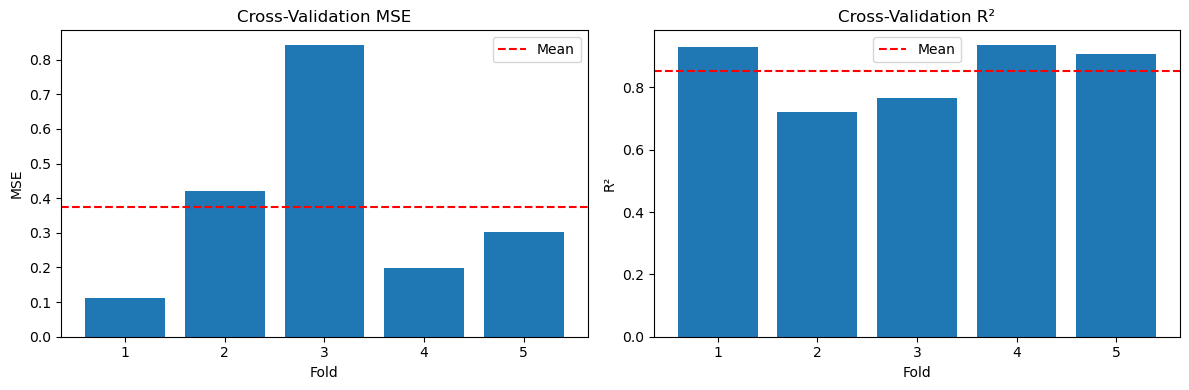

Training set size: 49
Test set size: 21

TRAIN-TEST SPLIT PERFORMANCE

Training:
  MSE: 0.4142
  RMSE: 0.6436
  R²: 0.8773

Test:
  MSE: 0.1317
  RMSE: 0.3629
  R²: 0.9160

R² difference (Train - Test): -0.0387


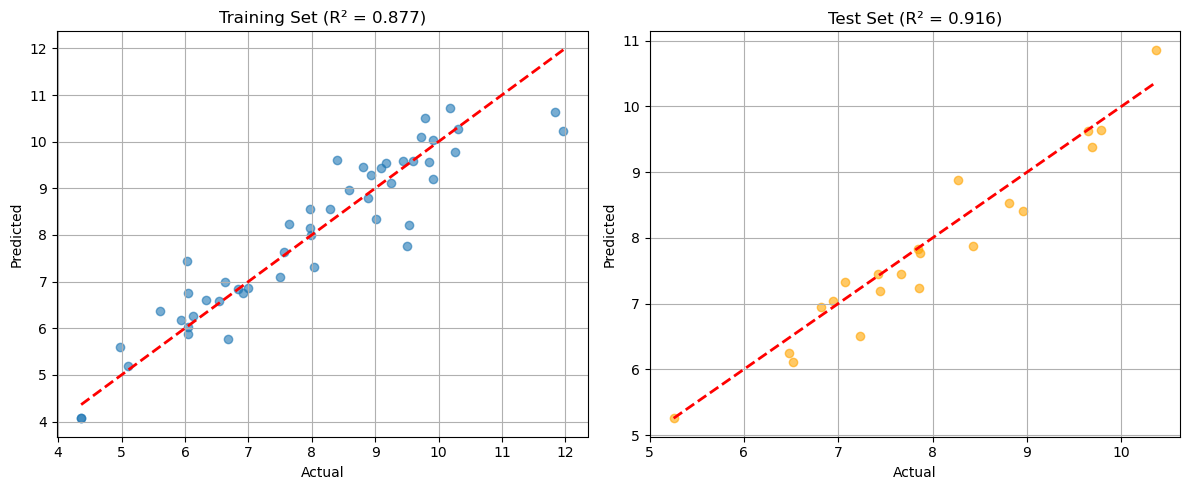

In [529]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

X_best = X_reduced[['waistcirc', 'anthro3c']].values
y_best = y_transformed

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# LinearRegression model
lr = LinearRegression()

# Scores
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

cv_mse = -cross_val_score(lr, X_best, y_best, cv=kf, scoring=mse_scorer)
cv_r2 = cross_val_score(lr, X_best, y_best, cv=kf, scoring=r2_scorer)

print("="*60)
print("CROSS-VALIDATION RESULTS (5-Fold)")
print("="*60)
print(f"\nMSE per fold:")
for i, mse in enumerate(cv_mse, 1):
    print(f"  Fold {i}: {mse:.4f}")
print(f"\nMean MSE: {cv_mse.mean():.4f} (±{cv_mse.std():.4f})")
print(f"Mean RMSE: {np.sqrt(cv_mse.mean()):.4f}")

print(f"\nR² per fold:")
for i, r2 in enumerate(cv_r2, 1):
    print(f"  Fold {i}: {r2:.4f}")
print(f"\nMean R²: {cv_r2.mean():.4f} (±{cv_r2.std():.4f})")

# Compare with R² of full model
print(f"\nR² on full data: {model_stepwise.rsquared:.4f}")
print(f"Difference (overfitting?): {model_stepwise.rsquared - cv_r2.mean():.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(range(1, 6), cv_mse)
axes[0].axhline(y=cv_mse.mean(), color='r', linestyle='--', label='Mean')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('MSE')
axes[0].set_title('Cross-Validation MSE')
axes[0].legend()

axes[1].bar(range(1, 6), cv_r2)
axes[1].axhline(y=cv_r2.mean(), color='r', linestyle='--', label='Mean')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('R²')
axes[1].set_title('Cross-Validation R²')
axes[1].legend()

plt.tight_layout()
plt.show()

from sklearn.model_selection import train_test_split

# 70-30 split
X_train, X_test, y_train, y_test = train_test_split(
    X_best, y_best, test_size=0.3, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Fit on train
lr.fit(X_train, y_train)

# Predict on test
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Metrics
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("\n" + "="*60)
print("TRAIN-TEST SPLIT PERFORMANCE")
print("="*60)
print(f"\nTraining:")
print(f"  MSE: {mse_train:.4f}")
print(f"  RMSE: {np.sqrt(mse_train):.4f}")
print(f"  R²: {r2_train:.4f}")

print(f"\nTest:")
print(f"  MSE: {mse_test:.4f}")
print(f"  RMSE: {np.sqrt(mse_test):.4f}")
print(f"  R²: {r2_test:.4f}")

print(f"\nR² difference (Train - Test): {r2_train - r2_test:.4f}")

# Actual vs Predicted plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train set
axes[0].scatter(y_train, y_pred_train, alpha=0.6)
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Training Set (R² = {r2_train:.3f})')
axes[0].grid(True)

# Test set
axes[1].scatter(y_test, y_pred_test, alpha=0.6, color='orange')
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Test Set (R² = {r2_test:.3f})')
axes[1].grid(True)

plt.tight_layout()
plt.show()

<b><span style="color:red;">Note: j'ai choisi le meilleure modèle a l'oeil d'apres le tableau je pense pas que ca soit très rigoureux essayer de trouver autre chose aussi prendre en compte outliers et multicolineraité j'ai pas fait mais il faudrait</span></b>


FINAL MODEL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     257.1
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           3.69e-32
Time:                        23:49:36   Log-Likelihood:                -60.186
No. Observations:                  70   AIC:                             126.4
Df Residuals:                      67   BIC:                             133.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1391      0.504     -6.

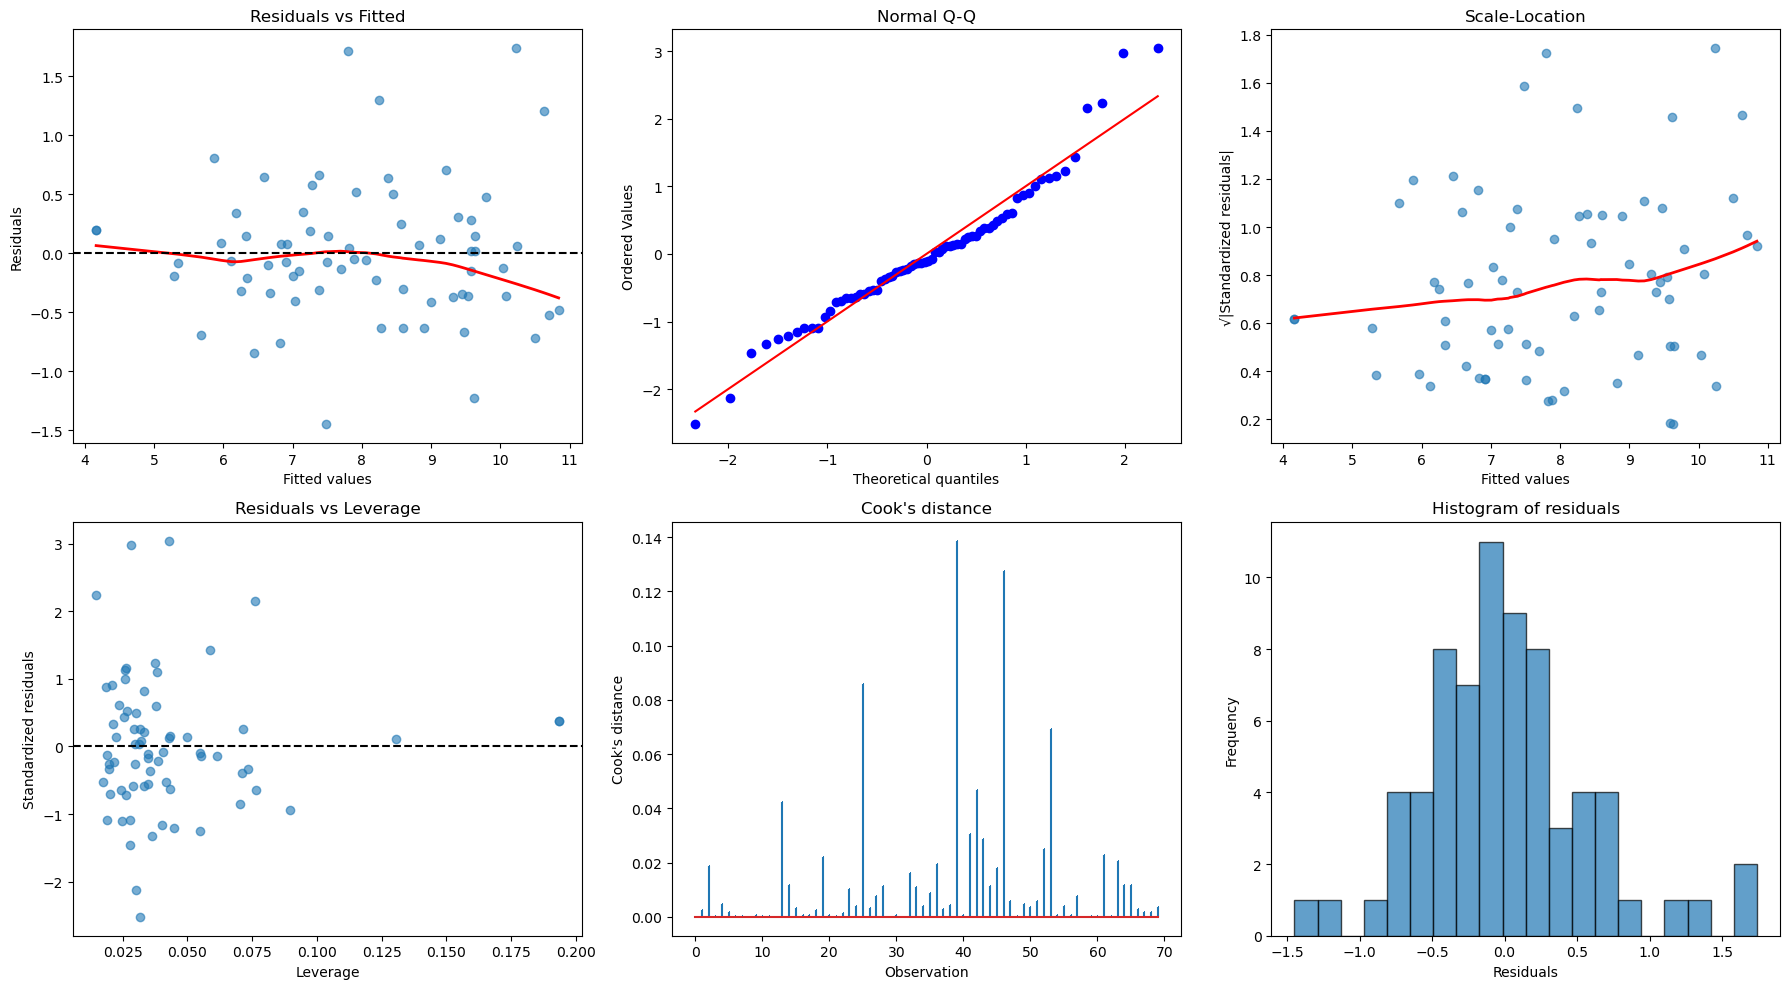

In [531]:
final_model_features = ['waistcirc', 'anthro3c']

X_final = X_reduced[final_model_features]
X_final_const = sm.add_constant(X_final)
model_final = sm.OLS(y_transformed, X_final_const).fit()

print("FINAL MODEL")
print(f"{'='*70}")
print(model_final.summary())
diagnostic(model_final)

## Bootstrap Methods

Bootstrap allows estimating the variability of model statistics by resampling.

### Residual Bootstrap (Montgomery §15.4.1)

Procedure:
1. Fit model on original data
2. Calculate residuals
3. Resample residuals with replacement
4. Generate new Y values: Y* = Ŷ + e*
5. Refit model on (X, Y*)
6. Repeat B times (e.g., B=1000)

In [532]:
from sklearn.utils import resample

print("BOOTSTRAP CONFIDENCE INTERVALS")
print(f"{'='*70}\n")

n_iterations = 1000
coefficients = []

X_final_array = X_final.values
y_final_array = y_transformed

for i in range(n_iterations):
    X_boot, y_boot = resample(X_final_array, y_final_array, random_state=i)
    
    X_boot_const = sm.add_constant(pd.DataFrame(X_boot, columns=final_model_features))
    model_boot = sm.OLS(y_boot, X_boot_const).fit()
    coefficients.append(model_boot.params.values)

coefficients = np.array(coefficients)

ci_lower = np.percentile(coefficients, 2.5, axis=0)
ci_upper = np.percentile(coefficients, 97.5, axis=0)

print("95% Bootstrap Confidence Intervals (Percentile Method):")
print("\nVariable          | OLS Estimate | Bootstrap CI")
print("-" * 60)
for i, var in enumerate(['const'] + final_model_features):
    ols_est = model_final.params.iloc[i]
    print(f"{var:17} | {ols_est:12.6f} | [{ci_lower[i]:9.6f}, {ci_upper[i]:9.6f}]")

print("\nComparison with OLS Confidence Intervals:")
print(model_final.conf_int())

print("\nInterpretation:")
print("If bootstrap CIs are similar to OLS CIs: assumptions (normality, etc.) are met")
print("If bootstrap CIs differ significantly: model assumptions may be violated")

BOOTSTRAP CONFIDENCE INTERVALS

95% Bootstrap Confidence Intervals (Percentile Method):

Variable          | OLS Estimate | Bootstrap CI
------------------------------------------------------------
const             |    -3.139088 | [-4.181558, -2.272581]
waistcirc         |     0.070445 | [ 0.057796,  0.084773]
anthro3c          |     1.272765 | [ 1.025288,  1.586260]

Comparison with OLS Confidence Intervals:
                  0         1
const     -4.144425 -2.133751
waistcirc  0.055620  0.085269
anthro3c   0.905730  1.639799

Interpretation:
If bootstrap CIs are similar to OLS CIs: assumptions (normality, etc.) are met
If bootstrap CIs differ significantly: model assumptions may be violated


In [ ]:


print("\n" + "="*70)
print("BOOTSTRAP RESIDUALS (Montgomery 15.4.1)")
print("="*70 + "\n")


n_boot = 1000
residuals = model_final.resid
fitted = model_final.fittedvalues

boot_predictions = []

# Fixer le seed pour reproductibilité
np.random.seed(42)

for i in range(n_boot):

    boot_resid = np.random.choice(residuals, size=len(residuals), replace=True)
    
    # Créer nouvelles réponses
    y_boot = fitted + boot_resid
    
    # Refit le modèle
    model_boot = sm.OLS(y_boot, X_final_const).fit()
    
    # Prédictions
    boot_predictions.append(model_boot.predict(X_final_const))

boot_predictions = np.array(boot_predictions)

# Intervalles de prédiction bootstrap
pred_intervals = np.percentile(boot_predictions, [2.5, 97.5], axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(y, fitted, alpha=0.5, label='Actual predictions')
plt.plot(y, pred_intervals[0, :], 'r.', alpha=0.3, label='Bootstrap 2.5%')
plt.plot(y, pred_intervals[1, :], 'r.', alpha=0.3, label='Bootstrap 97.5%')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect prediction')
plt.xlabel('Actual DEXfat')
plt.ylabel('Predicted DEXfat')
plt.title('Bootstrap Residuals - Prediction Intervals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Bootstrap residuals completed!")


BOOTSTRAP RESIDUALS (Montgomery 15.4.1)



ValueError: The indices for endog and exog are not aligned

<b><span style="color:red;">Note: définir explicitement le meilleur modèle: choix subset choix transfo etc </span></b>


### 7) Explore the need for further transformations.

<b><span style="color:red;">Note: j'ai fait que Box Cox. A faire avant selection best model</span></b>


### 8) Discuss with the subject - matter experts the relative advantages and disadvantages of the final set of models.

<b><span style="color:red;">Note: a faire avant selection best model</span></b>
